In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import prince
import importlib

import matplotlib.cm as cm
import numpy as np
from matplotlib.patches import Patch
import seaborn as sns
import matplotlib.lines as mlines
import matplotlib.cm as cm
import matplotlib.patches as mpatches

from networkx.algorithms import bipartite


import community as community_louvain
from netgraph import Graph

import sys
sys.path.insert(0, '../Utility files')

import utils2
from utils2 import *
import graphfunk
from graphfunk import *


## French Edge list creation

Redoing the entire pipeline for testing the network, only for the french subset. Las step before validation

In [2]:
#Load the edge list
#Load marker followers
full_path1 = '/home/livtollanes/NewData/markers_followers_cleaned_nolang.csv'
req_cols = ['marker_id', 'follower_id']
dtypes = {'marker_id': 'object',
          'follower_id': 'object'}

edgelist = pd.read_csv(full_path1, encoding='utf-8', dtype=dtypes, usecols=req_cols)

In [3]:
#Load french followers - to be used in the actual CA fitting process, and for updating the edgelist of markers and followers
full_path2 = '/home/livtollanes/NewData/french/french1.csv'

req_cols = ['follower_id', 'screen_name', 'description', 'description_cleantext', 'location', 'language', 'country','timestamp_utc']

dtypes = {
    'follower_id': 'object',
    'screen_name': 'object',
    'description': 'object',
    'description_cleantext': 'object',
    'location': 'object',
    'language': 'object',
    'country': 'object',
    'timestamp_utc': 'float64'
}

french_bios = pd.read_csv(full_path2, usecols=req_cols, dtype=dtypes, engine= 'python')

In [4]:
# Load the marker bios and rename ID columns
full_path = '/home/livtollanes/SocialMarkers/markers_bios_2023-05-19.csv'

req_cols = ['twitter_name', 'id', 'tweets', 'followers']

dtypes = {
    'twitter_name': 'object',
    'id': 'object',
    'description': 'object',
    'tweets': 'int64',
    'followers': 'int64'}

marker_ids = pd.read_csv(full_path, usecols=req_cols, dtype=dtypes)


#rename the twittwer id column to follower id 
marker_ids.rename(columns={'id':'marker_id'}, inplace=True)


In [5]:
# Full path to the Excel file where types and names of brands are stored
file_path = '/home/livtollanes/SocialMarkers/MarkersFrenchTwitter.xlsx'

# Load the Excel file - contains the full 236 brands + 
cats = pd.read_excel(file_path)

cats.drop_duplicates(inplace=True)

Create the informative edgelist and match with french users
Add twitter name, type, and followers to the edge list 

In [6]:
utils2.compare_column_values(edgelist, french_bios, column= "follower_id")

There are 1077439 unique values in df1 that don't exist in df2.
There are 0 unique values in df2 that don't exist in df1.


In [7]:
#map marker_ids onto cats from marker:ids
cat_id = cats.merge(marker_ids, on='twitter_name', how='left')
cat_id = cat_id.drop_duplicates(subset='marker_id')

In [8]:
#streamline the edgelist according to the french bio df. Only keep rows where follower ID exist in the french df
edgelist2 = utils2.streamline_IDs(source= french_bios, df_tofilter=edgelist, column= 'follower_id')

Number of unique follower_id in source DataFrame: 115093
Number of unique follower_id in filtered DataFrame after filtering: 115093
Removed 8427230 rows from the DataFrame to be filtered.
1186892 rows are left in the filtered DataFrame.


In [9]:
edgelist2['marker_id'].nunique()    

234

In [10]:
#One brand was removed. which one?
pd.set_option('display.max_rows', None)
first_rows1 = edgelist.drop_duplicates(subset='marker_id', keep='first')
first_rows2 = edgelist2.drop_duplicates(subset='marker_id', keep='first')


# Python
first_rows1[~first_rows1['marker_id'].isin(first_rows2['marker_id'])]


# Filter the DataFrame
filtered_df = edgelist[edgelist['marker_id'] == '882270183875915776']

# Print the number of rows
print(len(filtered_df))

cat_id.loc[cat_id['marker_id']== '882270183875915776'] 

#In the original edgelist (not only french users), there were 40 followers for sergio Tacchini. 
#When streamlining the edgelist to only include french people, this brand got removed entirely. These were all people categorised as non french in previpus steps.  

#edgelist.loc[edgelist['marker_id'] == '882270183875915776'] 

40


,marque,twitter_name,type,Unnamed: 3,marker_id,tweets,followers
22,Sergio Tacchini,SergioTacchiniA,sport,NaN,882270183875915776,79.0,310.0


In [11]:
#streamline cat_id. Only include ids in cat id that exist in the frencg edge list
cat_id_french = streamline_IDs(source = edgelist2, df_tofilter = cat_id, column= 'marker_id') # One of the brands didnt have any followers for some reason. (Famille et Education - Magazine de l'APEL)

Number of unique marker_id in source DataFrame: 234
Number of unique marker_id in filtered DataFrame after filtering: 234
Removed 3 rows from the DataFrame to be filtered.
234 rows are left in the filtered DataFrame.


In [12]:
cat_id[~cat_id['marker_id'].isin(cat_id_french['marker_id'])] #check where marker id in cat_id are not in cat_id french

,marque,twitter_name,type,Unnamed: 3,marker_id,tweets,followers
18,Napapijiri,Napapijiri97,sport,NaN,1059975643,8.0,1.0
22,Sergio Tacchini,SergioTacchiniA,sport,NaN,882270183875915776,79.0,310.0
89,Famille et Education - Magazine de l'APEL,NaN,magazine,NaN,NaN,NaN,NaN


In [13]:
category_id_nodupes = cat_id_french.drop_duplicates()

#Get the twitter_name column from cat_id into the edge list by merging on marker_id
edgelist_CA = edgelist2.merge(category_id_nodupes[['marker_id', 'twitter_name', 'type', 'followers']], on='marker_id', how='left')

In [14]:
# How many french followers do each brand have?

# Add 'french_followers' column
edgelist_CA['french_followers'] = edgelist_CA.groupby('marker_id')['marker_id'].transform('size')

# Sort by 'french_followers' in descending order
sorted_edgelist = edgelist_CA.sort_values(by='french_followers', ascending=False)



In [15]:
#Filter the french edgelist to only include markers that have more than n french followers 
importlib.reload(utils2)
# Use the function
sorted_edgelist_1, removed_info = utils2.min_french_followers(sorted_edgelist, 20)
removed_info

Total brands removed: 11


,twitter_name,followers,french_followers,type
1126305,LyceeNicoli,200.0,18,Lycées professionels
20874,FILAUSA,70402.0,18,sport
25104,Fabletics,37019.0,18,sport
1126210,GertyLycee,255.0,10,Lycées professionels
902693,EcologisteIdf,34.0,9,party
1126319,lpaugustinarron,171.0,9,Lycées professionels
1079596,UnivBesancon,52.0,8,universities
902701,UNESS_national,60.0,6,party
505715,PetitBateautn,178.0,2,luxe vetements et malls
25100,SauconyUK,7502.0,2,sport


In [16]:
sorted_edgelist_12 = utils2.filter_followers(df = sorted_edgelist_1, follower_id_column= 'follower_id', min_brands= 5)

14 followers follow less than 5 brands (0.01% of the total followers).
After removing these followers, 115079 followers are left (99.99% of the followers in the inputted df).


In [105]:
summary_stats(sorted_edgelist_12)

Shape of DataFrame:  (1186735, 6)

Columns in DataFrame:  ['marker_id', 'follower_id', 'twitter_name', 'type', 'followers', 'french_followers']

Data types of columns:
 marker_id            object
follower_id          object
twitter_name         object
type                 object
followers           float64
french_followers      int64
dtype: object

Number of unique values in 'follower_id':  115079
Number of duplicate values in 'follower_id':  1071656

Number of unique values in 'marker_id':  223
Number of duplicate values in 'marker_id':  1186512

Number of missing values in each column:
'marker_id':  0
'follower_id':  0
'twitter_name':  0
'type':  0
'followers':  0
'french_followers':  0

Number of duplicate rows:  0


In [17]:
# Create new groupings for brands
# Define the replacements
replacements = {
    'clubs de football': 'football clubs',
    'magazine': 'information',
    'media': 'information',
    'party': 'information',
    'sport': 'consumption',
    'luxe vetements et malls': 'consumption',
    'commerce': 'consumption',
    'grande distribution': 'consumption',
    'chain restaurants': 'consumption',
    'universities': 'education',
    'ecoles de commerce': 'education',
    'Lycées professionels': 'education'
}

# Replace the values
sorted_edgelist_12.loc[:,'type2'] = sorted_edgelist_12['type'].replace(replacements)

# Display the new DataFrame
sorted_edgelist_12.head()



/tmp/ipykernel_1591005/3141957187.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sorted_edgelist_12.loc[:,'type2'] = sorted_edgelist_12['type'].replace(replacements)


,marker_id,follower_id,twitter_name,type,followers,french_followers,type2
138619,19976004,1193293102162862080,Mediapart,media,3079643.0,64182,information
151137,19976004,2884619299,Mediapart,media,3079643.0,64182,information
151151,19976004,782999494703054848,Mediapart,media,3079643.0,64182,information
151150,19976004,124458686,Mediapart,media,3079643.0,64182,information
151149,19976004,2960220189,Mediapart,media,3079643.0,64182,information


In [107]:
summary_stats(sorted_edgelist_12)

Shape of DataFrame:  (1186735, 7)

Columns in DataFrame:  ['marker_id', 'follower_id', 'twitter_name', 'type', 'followers', 'french_followers', 'type2']

Data types of columns:
 marker_id            object
follower_id          object
twitter_name         object
type                 object
followers           float64
french_followers      int64
type2                object
dtype: object

Number of unique values in 'follower_id':  115079
Number of duplicate values in 'follower_id':  1071656

Number of unique values in 'marker_id':  223
Number of duplicate values in 'marker_id':  1186512

Number of missing values in each column:
'marker_id':  0
'follower_id':  0
'twitter_name':  0
'type':  0
'followers':  0
'french_followers':  0
'type2':  0

Number of duplicate rows:  0


In [108]:
# # #Now write the edgelist with a follower threshold to a csv file
sorted_edgelist_12.to_csv('/home/livtollanes/NewData/french/french_edgelist_marker_threshold.csv', sep=',', encoding='utf-8', index=False, quoting=csv.QUOTE_NONNUMERIC)

In [16]:
french1_updated = streamline_IDs(source = sorted_edgelist_12, df_tofilter = french_bios, column= 'follower_id')

Number of unique follower_id in source DataFrame: 115079
Number of unique follower_id in filtered DataFrame after filtering: 115079
Removed 14 rows from the DataFrame to be filtered.
115079 rows are left in the filtered DataFrame.


In [19]:
french1_updated.to_csv('/home/livtollanes/NewData/french/french1_updated.csv', sep=',', encoding='utf-8', index=False, quoting=csv.QUOTE_NONNUMERIC)

In [20]:
french1_updated.head()

,follower_id,screen_name,description,timestamp_utc,location,description_cleantext,language,country
0,2419429508,Max_Mth_,"Radio, web, magazine - culture, société, vie a...",1.396208e+09,"paris, france","Radio, web, magazine - culture, société, vie a...",fr,France
1,902419434358403072,Hellodie41,Ma thérapie : raconter ma vie a des gens qui n...,1.503989e+09,"blois, france",Ma thérapie : raconter ma vie a des gens qui n...,fr,France
2,44372703,julienmielcarek,Directeur des rédactions digitales BFM-RMC / C...,1.244040e+09,paris,Directeur des rédactions digitales BFM-RMC / C...,fr,France
3,1640041946,QDebrand,Directeur Adjoint @LDLC_Arena,1.375435e+09,"lyon, france",Directeur Adjoint @LDLC_Arena,fr,France
4,3118973117,jeanluc_bouchet,cadre informatique secteur hospitalier\nIntérê...,1.427383e+09,"betton, france",cadre informatique secteur hospitalierIntérêt ...,fr,France


## Graph Checks

In [18]:
# load data
path = '/home/livtollanes/NewData/french/french_edgelist_marker_threshold.csv'

req_cols = ['marker_id', 'follower_id', 'twitter_name','followers','french_followers', 'type', 'type2']
dtypes = {'marker_id': 'object',
          'follower_id': 'object',
          'twitter_name': 'object',
          'followers': 'int64',
          'french_followers': 'int64',
          'type': 'object',
          'type2': 'object'}


edgelist = pd.read_csv(path, usecols=req_cols, dtype=dtypes)

In [19]:

# Create a new bipartite graph
B = nx.DiGraph() #initialize a new directed graph

# Add nodes with the node attribute "bipartite"
B.add_nodes_from(edgelist['follower_id'].unique(), bipartite=0) #adding a node for each unique follower. Bipartite = 0 assigns followers to the first set in the graph.  Set 1 in the bipartite graph
B.add_nodes_from(edgelist['twitter_name'].unique(), bipartite=1) #adding a node for each unique marker. Set 2 in the bipartite graph
 
# Add edges
B.add_edges_from(list(zip(edgelist['follower_id'], edgelist['twitter_name'])))  #edges are directed from the first to the second element. So direction is; follower --> Marker

In [20]:
#sanity checks. Numbers of nodes and edges make sense. Graph seems to be connected
print("Number of nodes:", B.number_of_nodes())
print("Number of edges:", B.number_of_edges())

B_undirected = B.to_undirected()
print("Is the graph connected?", nx.is_connected(B_undirected))

Number of nodes: 115302
Number of edges: 1186735
Is the graph connected? True


#### Connectedness

- Test directed graph for weak connectivity. 
- Being weakly connected signifies that the graph is connected when the direction of the edge between nodes is ignored. 
- Thus, there is a path from any node to any other node in the graph when the direction of the edge between nodes is ignored.

In [21]:
# Calculate weakly connected components
connected_components = list(nx.weakly_connected_components(B))

# Print the number of connected components
print("Number of connected components:", len(connected_components))

# Print the size of the largest connected component
print("Size of largest connected component:", max(len(c) for c in connected_components))

Number of connected components: 1
Size of largest connected component: 115302


In [22]:
# Calculate strongly connected components
strongly_connected_components = list(nx.strongly_connected_components(B))

# Print the number of strongly connected components
print("Number of strongly connected components:", len(strongly_connected_components))

# Print the size of the largest strongly connected component
print("Size of largest strongly connected component:", max(len(c) for c in strongly_connected_components))

Number of strongly connected components: 115302
Size of largest strongly connected component: 1


A weakly connected component is a subgraph of the original graph where all vertices are connected to each other by some path, ignoring the direction of edges. Given our number of connected components is 1, we can conclude that our graph is fully connected. 

#### Degree distribution

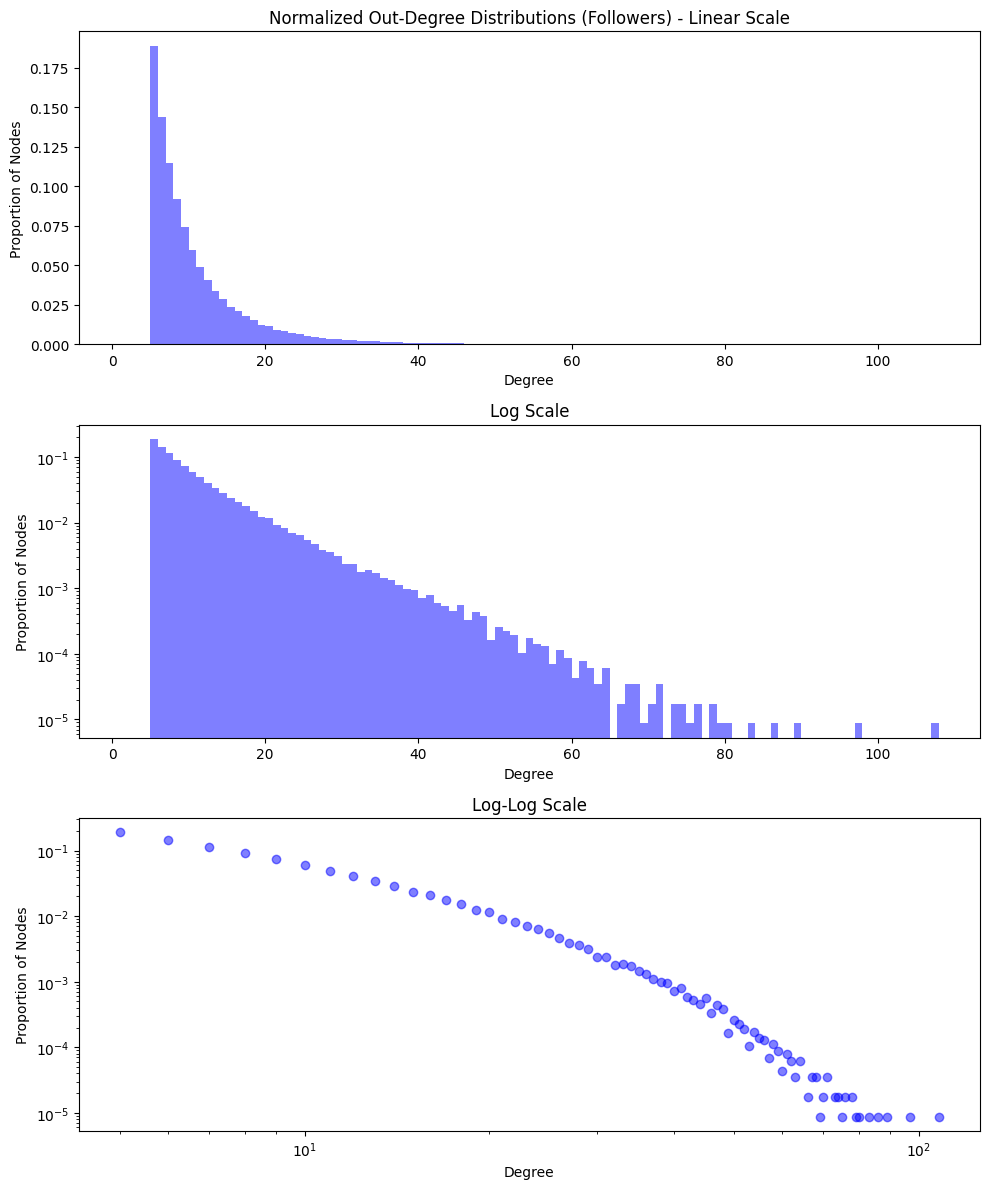

In [70]:
#Distribution for follower out degrees

# Separate nodes into two sets
followers, markers = bipartite.sets(B) #firs set is followers (set 0) and second is markers (set 1)

# Calculate out-degree for followers
out_degrees = [d for n, d in B.out_degree(followers)] #get out degrees for followers

# Calculate weights for each bin
weights = np.ones_like(out_degrees) / len(out_degrees)

# Create figure with three subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 12))

# First subplot with linear y-axis
axs[0].hist(out_degrees, bins=range(1, max(out_degrees) + 1), alpha=0.5, color='blue', weights=weights)
axs[0].set_title('Normalized Out-Degree Distributions (Followers) - Linear Scale')
axs[0].set_xlabel('Degree')
axs[0].set_ylabel('Proportion of Nodes')

# Second subplot with log y-axis
axs[1].hist(out_degrees, bins=range(1, max(out_degrees) + 1), alpha=0.5, color='blue', weights=weights)
axs[1].set_title('Log Scale')
axs[1].set_xlabel('Degree')
axs[1].set_ylabel('Proportion of Nodes')
axs[1].set_yscale('log')

# Third subplot with log-log scale
degrees, counts = np.unique(out_degrees, return_counts=True)
proportions = counts / len(out_degrees)
axs[2].scatter(degrees, proportions, color='blue', alpha=0.5)
axs[2].set_title('Log-Log Scale')
axs[2].set_xlabel('Degree')
axs[2].set_ylabel('Proportion of Nodes')
axs[2].set_yscale('log')
axs[2].set_xscale('log')

plt.tight_layout()
plt.show()

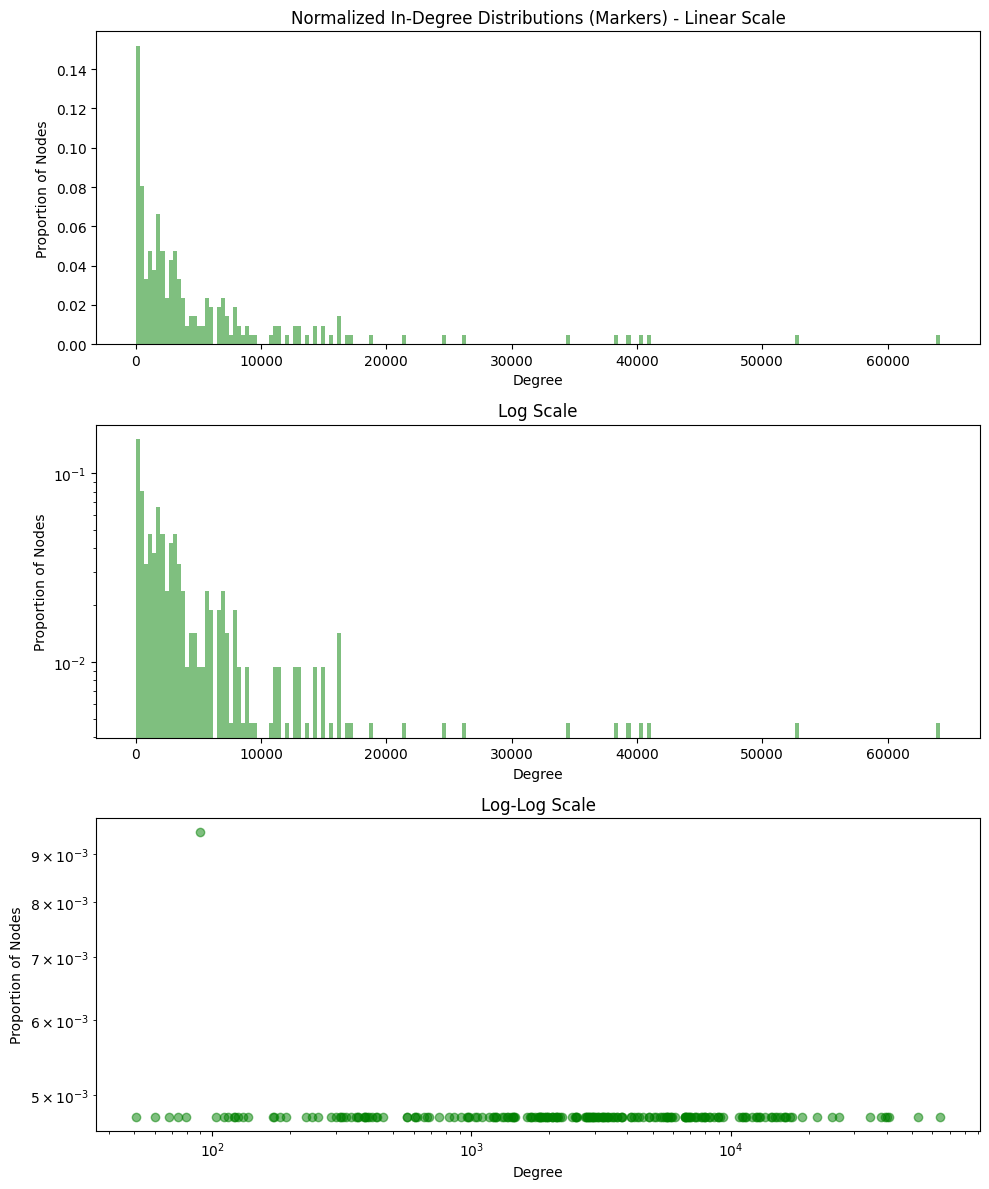

In [71]:
#Distributions for marker in degrees


# Separate nodes into two sets
followers, markers = bipartite.sets(B) #firs set is followers (set 0) and second is markers (set 1)

# Calculate in-degree for markers
in_degrees = [d for n, d in B.in_degree(markers)] #get in degrees for markers

# Calculate weights for each bin
weights = np.ones_like(in_degrees) / len(in_degrees)

# Create figure with three subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 12))

# First subplot with linear y-axis
axs[0].hist(in_degrees, bins=200, alpha=0.5, color='green', weights=weights)
axs[0].set_title('Normalized In-Degree Distributions (Markers) - Linear Scale')
axs[0].set_xlabel('Degree')
axs[0].set_ylabel('Proportion of Nodes')

# Second subplot with log y-axis
axs[1].hist(in_degrees, bins=200, alpha=0.5, color='green', weights=weights)
axs[1].set_title('Log Scale')
axs[1].set_xlabel('Degree')
axs[1].set_ylabel('Proportion of Nodes')
axs[1].set_yscale('log')

# Third subplot with log-log scale
degrees, counts = np.unique(in_degrees, return_counts=True)
proportions = counts / len(in_degrees)
axs[2].scatter(degrees, proportions, color='green', alpha=0.5)
axs[2].set_title('Log-Log Scale')
axs[2].set_xlabel('Degree')
axs[2].set_ylabel('Proportion of Nodes')
axs[2].set_yscale('log')
axs[2].set_xscale('log')

plt.tight_layout()
plt.show()

Complementary Cumulative Distribution Function (CCDF)
- The CCDF shows us the probability that a random variable is greater than a certain value
- CCDF is Basically just 1-CDF  (so instead of probability being below a certain value, it is the prob of being above)

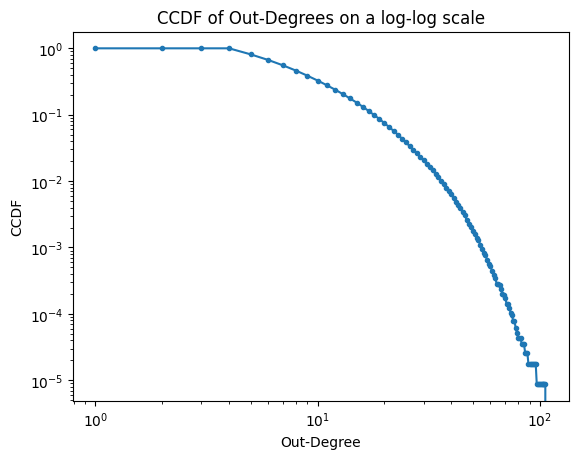

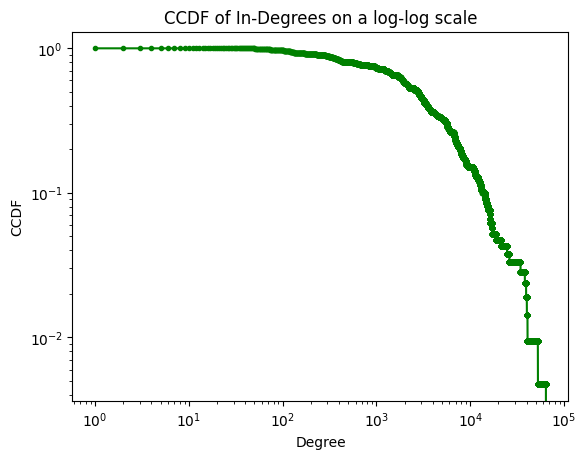

In [72]:
#complementary cumulative distribution function (CCDF) of the out-degrees of the followers

in_degrees = [d for n, d in B.in_degree(markers)]
out_degrees = [d for n, d in B.out_degree(followers)] #get out degrees for followers


degrees_out = np.array(out_degrees)
degrees_in = np.array(in_degrees)

# Calculate the complementary cumulative distribution function (CCDF) for out_degrees
counts, bin_edges = np.histogram(degrees_out, bins=range(1, max(degrees_out) + 1), density=True)
cum_counts = np.cumsum(counts)
ccdf = 1 - cum_counts

# Plot the CCDF on a log-log scale
plt.loglog(bin_edges[:-1], ccdf, marker='.')
plt.xlabel('Out-Degree')
plt.ylabel('CCDF')
plt.title('CCDF of Out-Degrees on a log-log scale')
plt.show()


# Calculate the complementary cumulative distribution function (CCDF)for in_degrees 
counts, bin_edges = np.histogram(degrees_in, bins=range(1, max(degrees) + 1), density=True)
cum_counts = np.cumsum(counts)
ccdf = 1 - cum_counts

# Plot the CCDF on a log-log scale
plt.loglog(bin_edges[:-1], ccdf, marker='.', color='green')
plt.xlabel('Degree')
plt.ylabel('CCDF')
plt.title('CCDF of In-Degrees on a log-log scale')
plt.show()


In [73]:
# What brands are have most in-degrees?
# Calculate in-degree centrality for all nodes in the graph
in_degree_centrality = nx.in_degree_centrality(B)

# Top 5 nodes by in-degree centrality
top_in_degree_nodes = sorted(in_degree_centrality.items(), key=lambda x: x[1], reverse=True)[10:20]

print("Top nodes by in-degree centrality:", top_in_degree_nodes)

Top nodes by in-degree centrality: [('LaTribune', 0.16394196560281843), ('lesRepublicains', 0.14989326807934608), ('ParisMatch', 0.14663056871626665), ('Renaissance', 0.14207493795664775), ('partisocialiste', 0.1410510057097239), ('Fnac', 0.14001839607087693), ('mdiplo', 0.13483799309279604), ('OM_Officiel', 0.13062078061817742), ('Reporterre', 0.12845143263740652), ('Cdiscount', 0.12539699068048107)]


#### Community Detection

Make projections to unipartite graphs. this way, we can look at the connectedness within each set in our graph. 
- In the projected marker graph, marker nodes are connected if they share a follower in the original graph.
- Follower nodes are connected if they follow the same marker in B
- This approach allows us to analyse what markers tend to be followed by the same people

In [74]:
#Project our bipartite graph onto two unipartite graphs
#We're going to look at the projections to identify communities

# Separate nodes into two sets
followers, markers = bipartite.sets(B) #firs set is followers (set 0) and second is markers (set 1)

# Convert to undirected graph
B_undirected = B.to_undirected()

# Create the projection for markers
G_markers = bipartite.projected_graph(B_undirected, markers) #unweighted projection

# Weighted projection for markers
G2_markers = bipartite.weighted_projected_graph(B_undirected, markers) 

#projection for followers
#G_followers = bipartite.projected_graph(B_undirected, followers)  #takes very long time, are we even interested in communities of followers?. Wait to run this code until I knwo

- unweighted: The edges do not carry any information about number of shared edges between nodes. An edge exists if two nodes share at least one neighbour in the original bipartite graph
- Weighted: Here, an edge exists if two nodes share at least one neighbour in the original bipartite graph just like for the unweighted. However, the weighted edges carry information about the number of shared neighbours between nodes


The weighted projected graph is the projection of the bipartite network B onto the specified nodes with weights representing the number of shared neighbors or the ratio between actual shared neighbors and possible shared neighbors if ratio is True [1]. The nodes retain their attributes and are connected in the resulting graph if they have an edge to a common node in the original graph.

In [75]:
#Get a list of the unique markers - to use  in plotting
unique_marker_df = edgelist.drop_duplicates(subset='marker_id')[['marker_id', 'twitter_name', 'type']]

# Create new groupings for brands

# Create a new DataFrame
new_types = unique_marker_df.copy()

# Define the replacements
replacements = {
    'clubs de football': 'football clubs',
    'magazine': 'information',
    'media': 'information',
    'party': 'information',
    'sport': 'consumption',
    'luxe vetements et malls': 'consumption',
    'commerce': 'consumption',
    'grande distribution': 'consumption',
    'chain restaurants': 'consumption',
    'universities': 'education',
    'ecoles de commerce': 'education',
    'Lycées professionels': 'education'
}

# Replace the values
new_types['type'] = new_types['type'].replace(replacements)

# Display the new DataFrame
new_types.head()

new_types['type'].unique()

array(['information', 'football clubs', 'consumption', 'education'],
      dtype=object)

- The spring layout for the plot below often takes into account the way in which nodes are connected. So here, the nodes close in space are more similarly connected than those far from each other.
- thus, the nodes placed outside of the main network relate to the network differently in terms of shared followers
- It is possible to make a weighted graph instead, but it didn't seem that much mroe useful

In [64]:
edgelist.head()

,marker_id,follower_id,twitter_name,type,followers,french_followers,type2
0,19976004,1193293102162862080,Mediapart,media,3079643,64159,information
1,19976004,2884619299,Mediapart,media,3079643,64159,information
2,19976004,782999494703054848,Mediapart,media,3079643,64159,information
3,19976004,124458686,Mediapart,media,3079643,64159,information
4,19976004,2960220189,Mediapart,media,3079643,64159,information


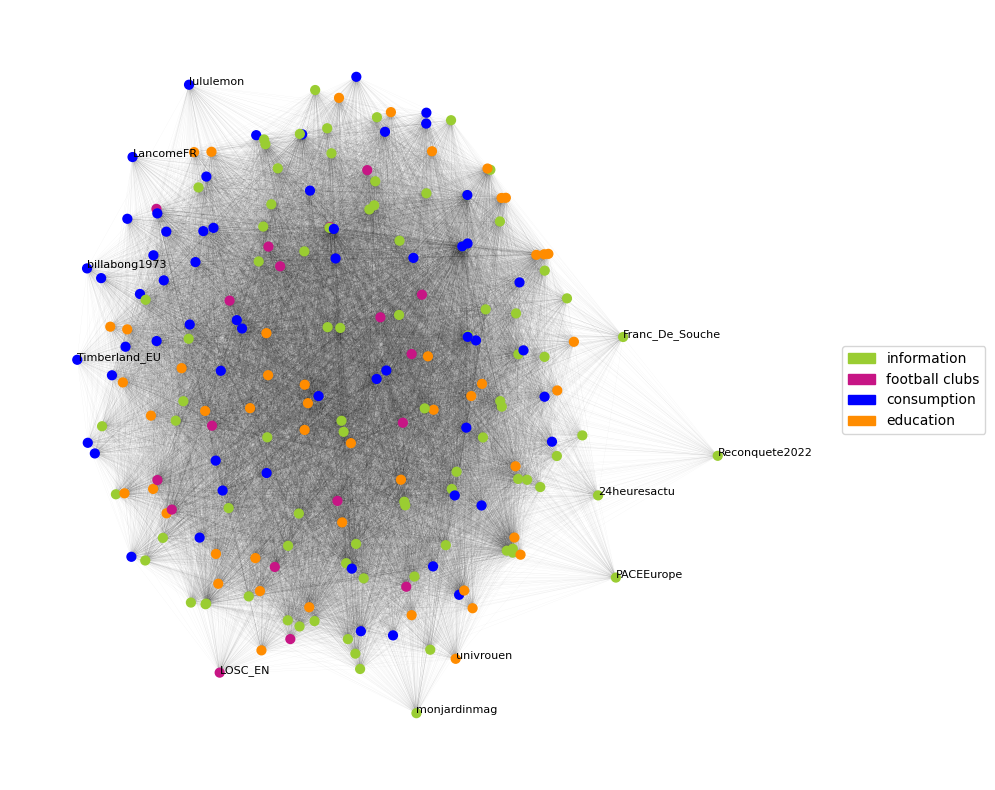

In [78]:
# Plot of brands' relations in terms of shared followers

color_dict = {'consumption': 'blue', 'information': 'yellowgreen', 'football clubs': 'mediumvioletred', 'education': 'darkorange'}

# Get the unique types and assign a color to each one
unique_types = edgelist['type2'].unique()
type_color = {utype: color_dict[utype] for utype in unique_types}

# Create a dictionary that maps each twitter_name to its type
twitter_name_to_type = dict(zip(edgelist['twitter_name'], edgelist['type2']))

# Create a list of colors for each node in the graph
node_colors = [type_color[twitter_name_to_type[node]] for node in G_markers.nodes()]

# Draw the graph with node colors
plt.figure(figsize=(10, 10))  # Increase figure size
pos = nx.spring_layout(G_markers)  # Use spring layout

# Draw edges with increased alpha
nx.draw_networkx_edges(G_markers, pos, alpha=0.1, width=0.1)

# Draw nodes with original alpha and node colors
nx.draw_networkx_nodes(G_markers, pos, node_color=node_colors, node_size=40, alpha=1.0)

# Calculate the center of the graph by averaging the positions of all nodes
center = np.array([0.0, 0.0])  # Initialize as float array
for coord in pos.values():
    center += np.array(coord)
center /= len(pos)

# Define the distance for nodes to be considered "outside the main cluster"
distance = 0.7

# Draw labels for nodes outside the main cluster
for node, coord in pos.items():
    if np.linalg.norm(np.array(coord) - center) > distance:
        plt.text(coord[0], coord[1], node, fontsize=8)

# Create legend
patches = [mpatches.Patch(color=color, label=utype) for utype, color in type_color.items()]
plt.legend(handles=patches, loc='center left', bbox_to_anchor=(0.95, 0.5), bbox_transform=plt.gcf().transFigure)

# Remove axes
plt.axis('off')

plt.show()

It makes the most sense to use community detection algorithms on undirected, unipartite graphs. Therefore, I'm doing the detection on the projections of markers and followers instead. ***** Double check whetrher this choice is correct!

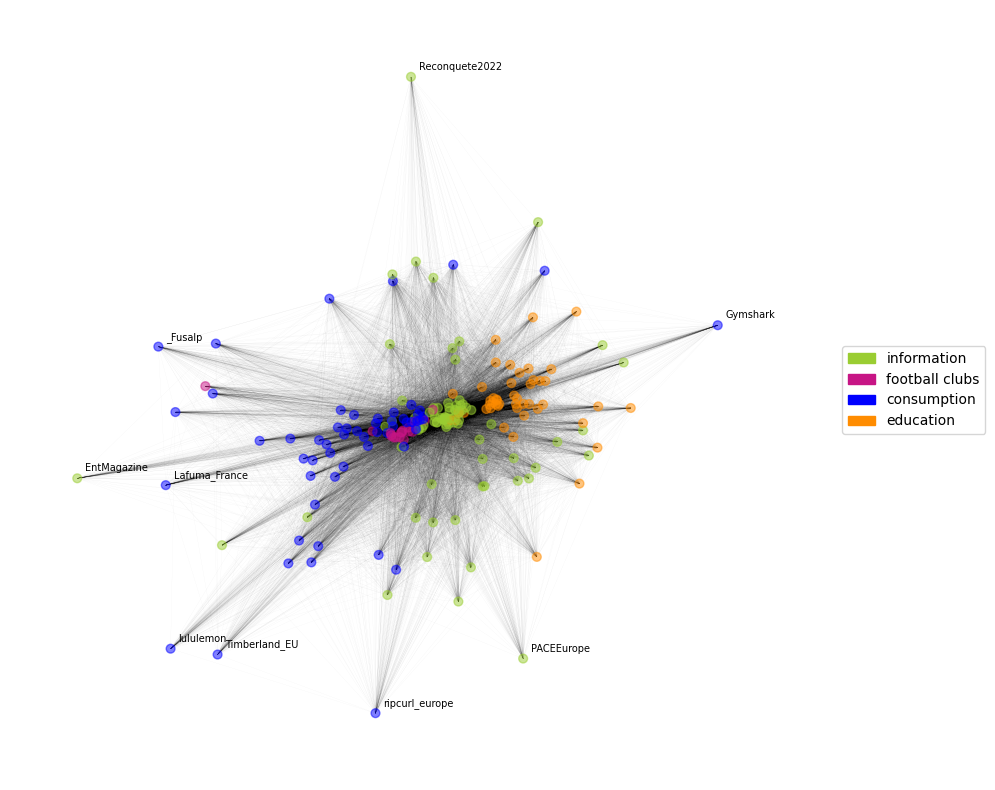

In [79]:
# Plot of brands' relations in terms of shared followers

color_dict = {'consumption': 'blue', 'information': 'yellowgreen', 'football clubs': 'mediumvioletred', 'education': 'darkorange'}

# Get the unique types and assign a color to each one
unique_types = edgelist['type2'].unique()
type_color = {utype: color_dict[utype] for utype in unique_types}

# Create a dictionary that maps each twitter_name to its type
twitter_name_to_type = dict(zip(edgelist['twitter_name'], edgelist['type2']))

# Create a list of colors for each node in the graph
node_colors = [type_color[twitter_name_to_type[node]] for node in G2_markers.nodes()]

# Draw the graph with node colors
plt.figure(figsize=(10, 10))  # Increase figure size
pos = nx.spring_layout(G2_markers, weight='weight')  # Use spring layout

# Draw edges with increased alpha
nx.draw_networkx_edges(G2_markers, pos, alpha=0.09, width=0.1)

# Draw nodes with original alpha and node colors
nx.draw_networkx_nodes(G2_markers, pos, node_color=node_colors, node_size=40, alpha=0.5)

# Calculate the center of the graph by averaging the positions of all nodes
center = np.array([0.0, 0.0])  # Initialize as float array
for coord in pos.values():
    center += np.array(coord)
center /= len(pos)

# Define the distance for nodes to be considered "outside the main cluster"
distance = 0.7

# Draw labels for nodes outside the main cluster
for node, coord in pos.items():
    if np.linalg.norm(np.array(coord) - center) > distance:
        plt.text(coord[0] + 0.02, coord[1] + 0.02, node, fontsize=7)

# Create legend
patches = [mpatches.Patch(color=color, label=utype) for utype, color in type_color.items()]
plt.legend(handles=patches, loc='center left', bbox_to_anchor=(0.95, 0.5), bbox_transform=plt.gcf().transFigure)

# Remove axes
plt.axis('off')

plt.show()

In [80]:
#Calculate communities in the weighted marker network

# Compute the best partition using the Louvain method
partition = community_louvain.best_partition(G2_markers) #result is a dict where key = node and value = community

# Get the number of unique communities
num_communities = len(set(partition.values()))

print(f"Number of communities: {num_communities}")

Number of communities: 4


In [81]:
from collections import defaultdict

brand_types = dict(zip(edgelist['twitter_name'], edgelist['type2']))

# Create a nested dictionary where the keys are the community labels and the values are dictionaries with types and counts
communities = defaultdict(lambda: defaultdict(int))
for brand, community in partition.items():
    brand_type = brand_types.get(brand, 'Unknown')
    communities[community][brand_type] += 1

# Print the count of each type in each community, sorted by count in descending order
for community, types in communities.items():
    print(f"Community {community}:")
    for brand_type, count in sorted(types.items(), key=lambda item: item[1], reverse=True):
        print(f"  {brand_type}: {count}")
    print()

Community 0:
  information: 59

Community 2:
  consumption: 38
  football clubs: 18
  information: 12

Community 3:
  consumption: 21
  information: 11

Community 1:
  education: 48
  information: 4



In [93]:
# Group the brands by community
brands_by_community = {}
for brand, community in partition.items():
    if community not in brands_by_community:
        brands_by_community[community] = []
    brands_by_community[community].append(brand)

# Print the brands and their types in each community, in ascending order of community number
for community in sorted(brands_by_community.keys()):
    brands = brands_by_community[community]
    print(f"Community {community}:")
    for brand in brands:  # Brand names are printed
        brand_type = brand_types.get(brand, 'Unknown')  # Get the type of the brand
        print(f"  {brand} ({brand_type})")  # Print the brand name and its type
    print()

Community 0:
  LesCentristes_ (information)
  Valeurs (information)
  Causeur (information)
  Mediapart (information)
  nationalistesfr (information)
  franceculture (information)
  Reporterre (information)
  LaTribune (information)
  mdiplo (information)
  lesRepublicains (information)
  InvestirFr (information)
  Telerama (information)
  fipradio (information)
  _LesPatriotes (information)
  Lagazettefr (information)
  RSouveraine (information)
  MoDem (information)
  RevPermanente (information)
  Renaissance (information)
  humanite_fr (information)
  FranceInsoumise (information)
  lesinrocks (information)
  LeMediaTV (information)
  UDMF_officiel (information)
  FortuneMagazine (information)
  francebleu (information)
  france_soir (information)
  PartiAnimaliste (information)
  TheatrumBelli (information)
  LutteOuvriere (information)
  UPR_Officiel (information)
  Franc_De_Souche (information)
  LEXPRESS (information)
  DLF_Officiel (information)
  FigaroMagazine_ (information)


In [82]:

# Create a dictionary to hold the data
data = defaultdict(list)

# Populate the dictionary with brand-community pairs
for brand, community in partition.items():
    data[community].append(brand)

# Create a DataFrame from the dictionary
df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in data.items() ]))

# The DataFrame now has a separate column for each community, with the brands in each community listed in that column
pd.set_option('display.max_rows', None)
print(df)

                  0                2                3                1
0     UDMF_officiel       ToulouseFC      VogueFrance            essec
1      DLF_Officiel      ASICSFrance   ripcurl_europe       UnivAngers
2       Renaissance            Tele7  Journal_Palaces          cdf1530
3     _LesPatriotes           sofoot  Cosmopolitan_fr         HECParis
4         le_gorafi        FCLorient              YSL  FortuneMagazine
5    lanouvellerep_      Telestarmag  marksandspencer    univbourgogne
6        ParisMatch           vinted    VeuveClicquot        UnivLyon1
7           Europe1     ClermontFoot    femmeactuelle          unistra
8          fipradio               OL        GQ_France   Paris_Dauphine
9         LaTribune      OnzeMondial          Moncler            IESEG
10    LutteOuvriere          Leclerc          Cartier       UnivParis8
11  Franc_De_Souche         adidasFR       Quiksilver        univrouen
12  nationalistesfr      intermarche    Timberland_EU          ESCP_bs
13    

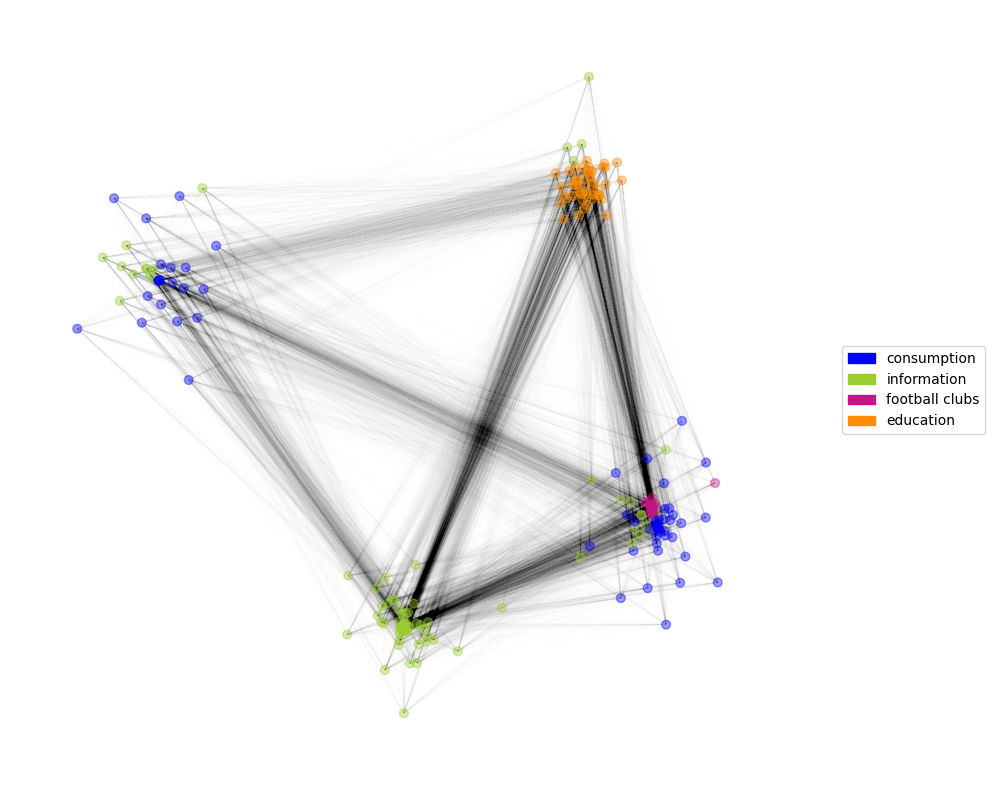

In [83]:
color_dict = {'consumption': 'blue', 'information': 'yellowgreen', 'football clubs': 'mediumvioletred', 'education': 'darkorange'}
twitter_name_to_type = dict(zip(edgelist['twitter_name'], edgelist['type2']))
node_colors = [color_dict[twitter_name_to_type[node]] for node in G_markers.nodes()]
pos = graphfunk.community_layout(G2_markers, partition)

plt.figure(figsize=(10, 10))
nx.draw_networkx_nodes(G2_markers, pos, node_color=node_colors, node_size=40, alpha=0.4)
nx.draw_networkx_edges(G2_markers, pos, alpha=0.005)  
patches = [mpatches.Patch(color=color, label=utype) for utype, color in color_dict.items()]
plt.legend(handles=patches, loc='center left', bbox_to_anchor=(0.95, 0.5), bbox_transform=plt.gcf().transFigure)
plt.axis('off')
plt.show()

## The CA

- Create contingency table (rows are users, columns are brands)
- each cell represents the frequency of interaction between user and brand


In [3]:
# load data
path = '/home/livtollanes/NewData/french/french_edgelist_marker_threshold.csv'

req_cols = ['marker_id', 'follower_id', 'twitter_name','followers','french_followers', 'type', 'type2']
dtypes = {'marker_id': 'object',
          'follower_id': 'object',
          'twitter_name': 'object',
          'followers': 'int64',
          'french_followers': 'int64',
          'type': 'object',
          'type2': 'object'}


edgelist_CA = pd.read_csv(path, usecols=req_cols, dtype=dtypes)

In [86]:
summary_stats(edgelist_CA)

Shape of DataFrame:  (1186194, 7)

Columns in DataFrame:  ['marker_id', 'follower_id', 'twitter_name', 'type', 'followers', 'french_followers', 'type2']

Data types of columns:
 marker_id           object
follower_id         object
twitter_name        object
type                object
followers            int64
french_followers     int64
type2               object
dtype: object

Number of unique values in 'follower_id':  115032
Number of duplicate values in 'follower_id':  1071162

Number of unique values in 'marker_id':  211
Number of duplicate values in 'marker_id':  1185983

Number of missing values in each column:
'marker_id':  0
'follower_id':  0
'twitter_name':  0
'type':  0
'followers':  0
'french_followers':  0
'type2':  0

Number of duplicate rows:  0


In [105]:
edgelist_CA.head()

,marker_id,follower_id,twitter_name,type,followers,french_followers,type2
0,19976004,1193293102162862080,Mediapart,media,3079643,64182,information
1,19976004,2884619299,Mediapart,media,3079643,64182,information
2,19976004,782999494703054848,Mediapart,media,3079643,64182,information
3,19976004,124458686,Mediapart,media,3079643,64182,information
4,19976004,2960220189,Mediapart,media,3079643,64182,information


In [4]:
#creating the contingency table
contingency_table = pd.crosstab(edgelist_CA['follower_id'], edgelist_CA['twitter_name'])

# Initialize a CA object
ca = prince.CA(
    n_components=100,  # Number of components to keep
    n_iter=100,  # Number of iterations for the power method
    copy=True,  # Whether to overwrite the data matrix
    check_input=True,  # Whether to check the input for NaNs and Infs
    engine='sklearn',  # Whether to perform computations in C or Python
    random_state=42  # Random seed for reproducibility
)

# Fit the CA model on the contingency table
ca = ca.fit(contingency_table)

# Get the coordinates of the rows (followers) and columns (brands) 
row_coordinates = ca.row_coordinates(contingency_table)
column_coordinates = ca.column_coordinates(contingency_table)


In [123]:
column_coordinates.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
twitter_name,,,,,,,,,,,,,,,,,,,,,
24heuresactu,-0.293984,-0.578044,-0.119875,0.021051,0.680728,-0.316786,-0.659470,-0.197418,-0.243188,-0.204380,...,1.969438,-3.561458,1.620228,5.119642,-0.244709,-0.229280,-0.412554,-0.576843,0.833426,-0.858696
ACAjaccio,1.832167,0.904448,-1.652958,-1.353157,-0.025558,-0.041948,0.006717,0.720903,0.116874,-0.266917,...,0.077639,0.259359,0.037048,0.128661,0.006515,-0.057395,-0.044863,-0.101117,-0.128680,0.126297
AJA,1.762507,0.846269,-1.483433,-1.039978,-0.071851,-0.028801,0.007450,0.607826,0.106165,-0.197251,...,0.101831,0.412403,0.207750,0.224529,0.006848,-0.106476,-0.009147,-0.175733,-0.260917,0.140963
ASICSFrance,0.967124,0.260845,0.350225,-0.060710,-0.041817,0.041196,0.222464,-0.809558,0.157002,0.189904,...,-2.018739,0.024007,1.779610,0.427759,-1.336113,-0.679442,1.009443,-0.617206,-0.444078,0.337535
AS_Monaco,1.553025,0.644270,-1.086671,-0.801687,0.015671,-0.004364,0.055782,0.092235,0.042278,-0.003471,...,-0.147270,-0.195817,-0.178783,-0.031636,0.210510,-0.058960,-0.043540,-0.066657,-0.021473,-0.042547


In the context of CA, inertia is equivalent to variance. Double check this

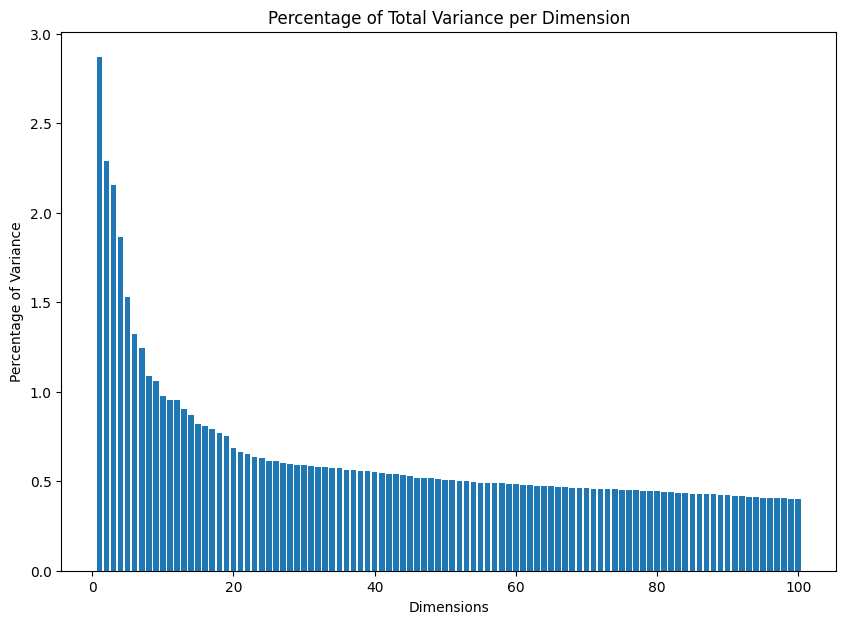

In [5]:
# Python
import matplotlib.pyplot as plt

percentage_of_variance = ca.percentage_of_variance_

# Create a range of numbers for x axis
dimensions = range(1, len(percentage_of_variance) + 1)

# Create the plot
plt.figure(figsize=(10, 7))
plt.bar(dimensions, percentage_of_variance)
plt.xlabel('Dimensions')
plt.ylabel('Percentage of Variance')
plt.title('Percentage of Total Variance per Dimension')
plt.show()

In [167]:
edgelist_CA.head()

,marker_id,follower_id,twitter_name,type,followers,french_followers,type2
0,19976004,1193293102162862080,Mediapart,media,3079643,64182,information
1,19976004,2884619299,Mediapart,media,3079643,64182,information
2,19976004,782999494703054848,Mediapart,media,3079643,64182,information
3,19976004,124458686,Mediapart,media,3079643,64182,information
4,19976004,2960220189,Mediapart,media,3079643,64182,information


In [171]:
unique_sorted_edgelist.head()   

,marker_id,follower_id,twitter_name,type,followers,french_followers,type2
0,19976004,1193293102162862080,Mediapart,media,3079643,64182,information
99236,133663801,1479073429,BFMTV,media,3972517,52645,information
143978,13353862,102117313,LEXPRESS,magazine,1473561,40800,information
184330,36383320,248138023,franceculture,media,925720,40152,information
223978,34570323,909681,Europe1,media,1638745,39404,information


In [172]:
merged_df.head()

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,twitter_name,french_followers
1182683,-0.293984,-0.578044,-0.119875,0.021051,0.680728,-0.316786,-0.659470,-0.197418,-0.243188,-0.204380,...,1.620228,5.119642,-0.244709,-0.229280,-0.412554,-0.576843,0.833426,-0.858696,24heuresactu,300
1091291,1.832167,0.904448,-1.652958,-1.353157,-0.025558,-0.041948,0.006717,0.720903,0.116874,-0.266917,...,0.037048,0.128661,0.006515,-0.057395,-0.044863,-0.101117,-0.128680,0.126297,ACAjaccio,2521
1021114,1.762507,0.846269,-1.483433,-1.039978,-0.071851,-0.028801,0.007450,0.607826,0.106165,-0.197251,...,0.207750,0.224529,0.006848,-0.106476,-0.009147,-0.175733,-0.260917,0.140963,AJA,3349
1157691,0.967124,0.260845,0.350225,-0.060710,-0.041817,0.041196,0.222464,-0.809558,0.157002,0.189904,...,1.779610,0.427759,-1.336113,-0.679442,1.009443,-0.617206,-0.444078,0.337535,ASICSFrance,1246
780994,1.553025,0.644270,-1.086671,-0.801687,0.015671,-0.004364,0.055782,0.092235,0.042278,-0.003471,...,-0.178783,-0.031636,0.210510,-0.058960,-0.043540,-0.066657,-0.021473,-0.042547,AS_Monaco,7751


In [173]:
# Sort by 'french_followers' in descending order
sorted_edgelist = edgelist_CA.sort_values(by='french_followers', ascending=False)


# Drop duplicate rows based on 'marker_id'
unique_sorted_edgelist = sorted_edgelist.drop_duplicates(subset='marker_id')


# Create a DataFrame that maps twitter_name to type
twitter_name_to_type1 = new_types.set_index('twitter_name')['type']
twitter_name_to_type2 = new_types.set_index('twitter_name')['type2']

# Add a 'type' column to column_coordinates
column_coordinates['type2'] = twitter_name_to_type2
column_coordinates['type1'] = twitter_name_to_type1


# Merge the 'french_followers' data with the brands data
merged_df = pd.merge(column_coordinates, unique_sorted_edgelist[['twitter_name', 'french_followers']], left_index=True, right_on='twitter_name')

# Define the number of intervals
num_intervals = 4

# Calculate the width of each interval
interval_width = (merged_df.iloc[:, 0].max() - merged_df.iloc[:, 0].min()) / num_intervals

# Create a list to store the selected brands
selected_brands = []

# For each interval, select the top 10 brands with the most followers
for i in range(num_intervals):
    lower_bound = merged_df.iloc[:, 0].min() + i * interval_width
    upper_bound = lower_bound + interval_width
    interval_brands = merged_df[(merged_df.iloc[:, 0] >= lower_bound) & (merged_df.iloc[:, 0] < upper_bound)]
    top_brands = interval_brands.sort_values(by='french_followers', ascending=False).head(10)
    selected_brands.append(top_brands)

# Combine the selected brands from each interval into a single dataframe
selected_brands_df = pd.concat(selected_brands)

In [170]:
# Group by 'type' and select the top 10 brands with the most followers in each group
selected_brands2 = merged_df.groupby('type2').apply(lambda x: x.nlargest(20, 'french_followers'))

# Reset the index
selected_brands2.reset_index(drop=True, inplace=True)

KeyError: 'type'

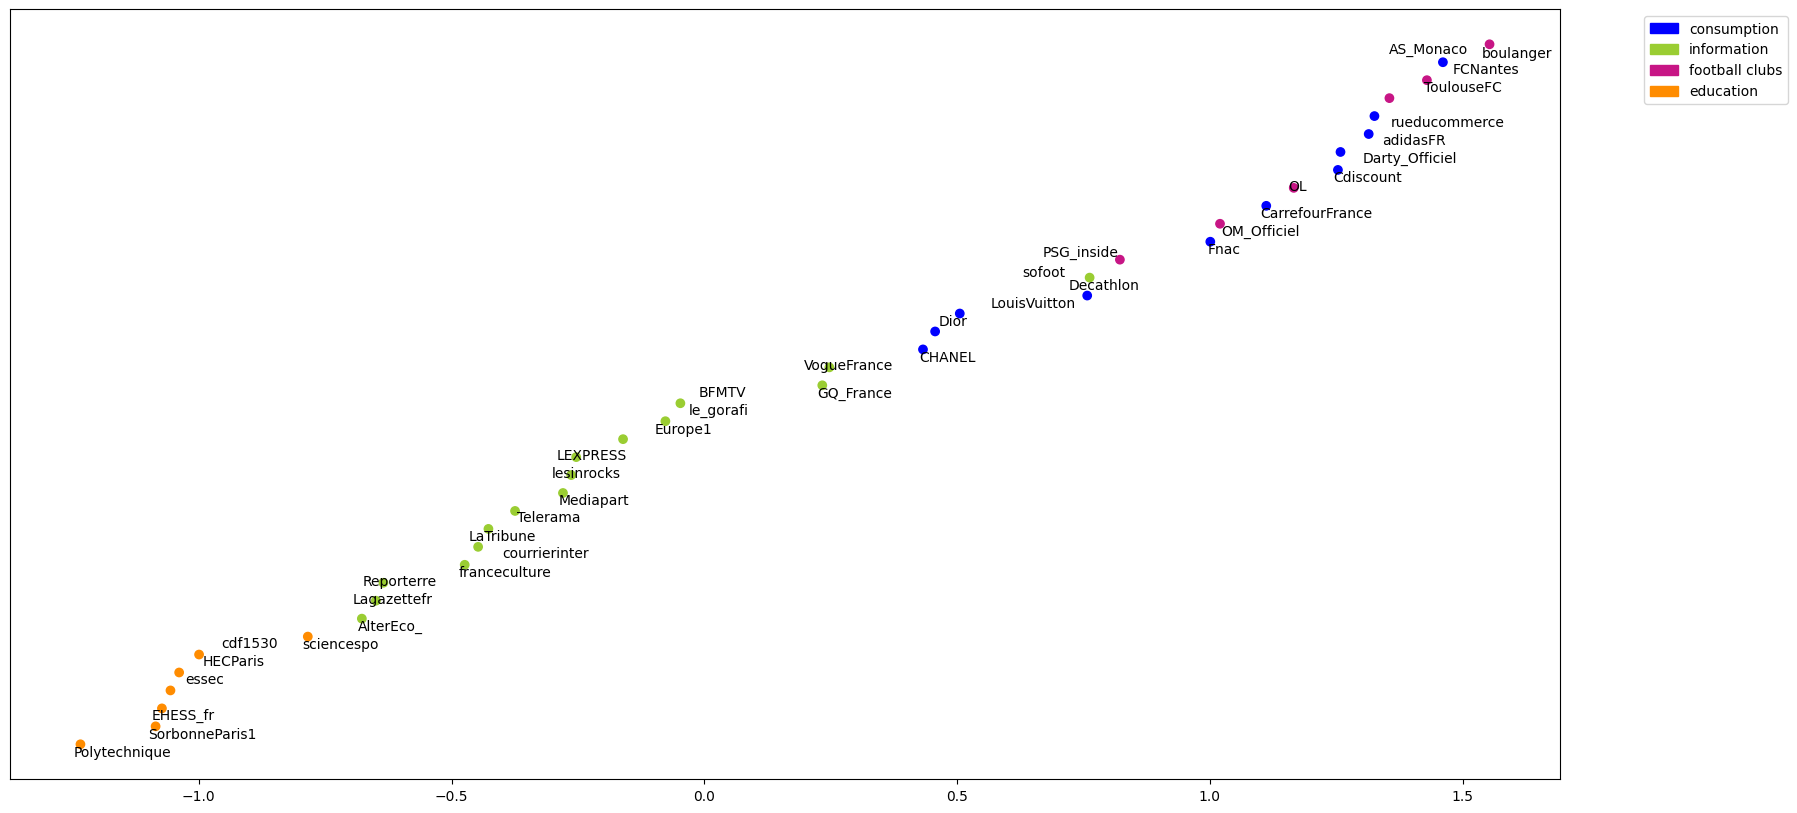

In [174]:
importlib.reload(graphfunk)
graphfunk.plot_brands(selected_brands_df, selected_brands_df.columns[0])

In [42]:
unique_sorted_edgelist['type'].unique()

array(['media', 'magazine', 'clubs de football', 'party', 'commerce',
       'luxe vetements et malls', 'grande distribution', 'universities',
       'sport', 'chain restaurants', 'ecoles de commerce',
       'Lycées professionels'], dtype=object)

In [56]:

# Filter the DataFrame for the specific 'type'
filtered_df = new_types[new_types['type'] == 'information']


pd.set_option('display.max_rows', None)
filtered_df


,marker_id,twitter_name,type,followers,french_followers
138619,19976004,Mediapart,information,3079643,64182
315665,133663801,BFMTV,information,3972517,52645
718104,13353862,LEXPRESS,information,1473561,40800
254842,36383320,franceculture,information,925720,40152
347887,34570323,Europe1,information,1638745,39404
237183,492648852,le_gorafi,information,1412986,38208
669721,16097522,lesinrocks,information,1104362,34371
580260,67278158,Telerama,information,397300,26135
739041,83864876,courrierinter,information,411957,24710
402709,137253079,LaTribune,information,260109,18895


/home/livtollanes/10.jan-thesis/Code/Graph preparation/../Utility files/graphfunk.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  texts.append(plt.text(column_coordinates_type_sorted[dimension][i], y_values[i], twitter_name))


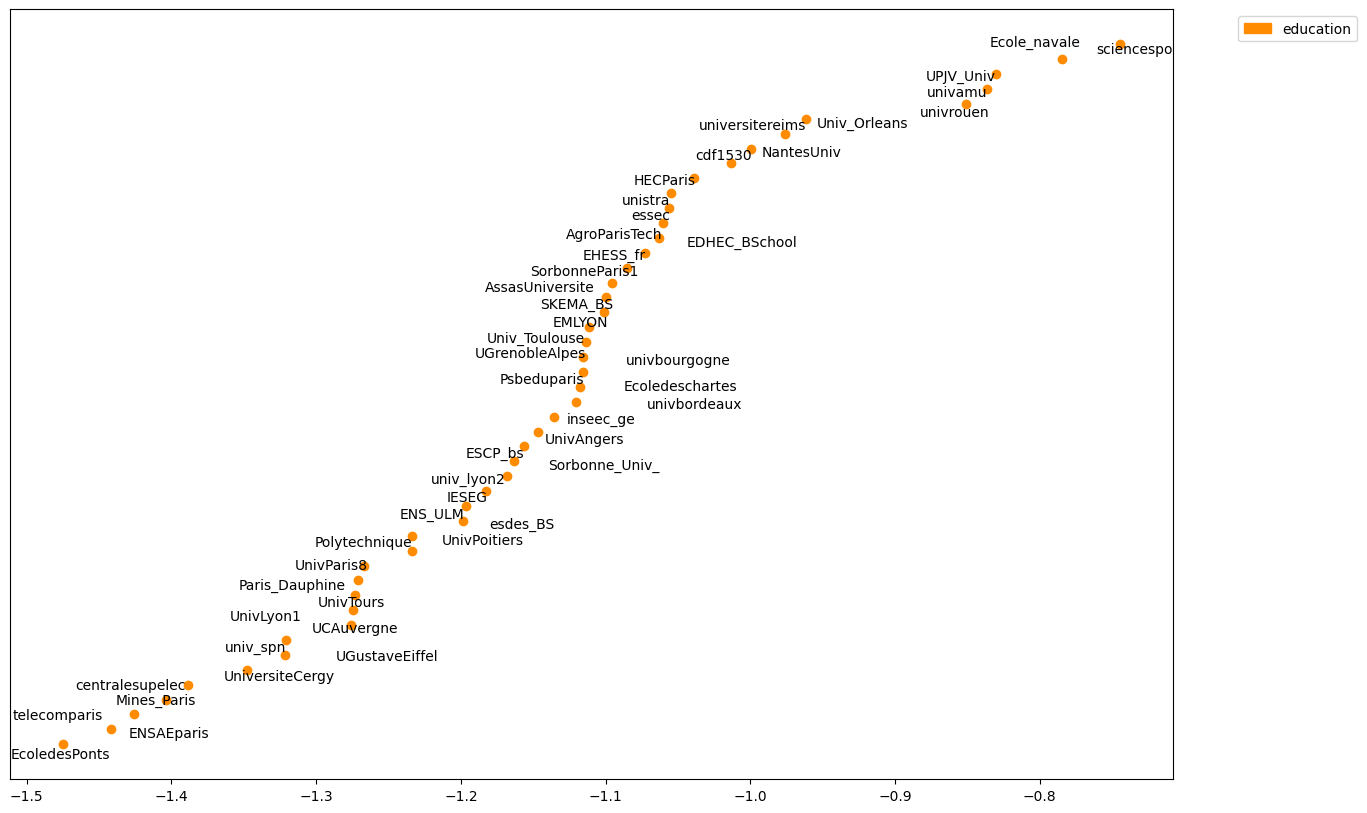

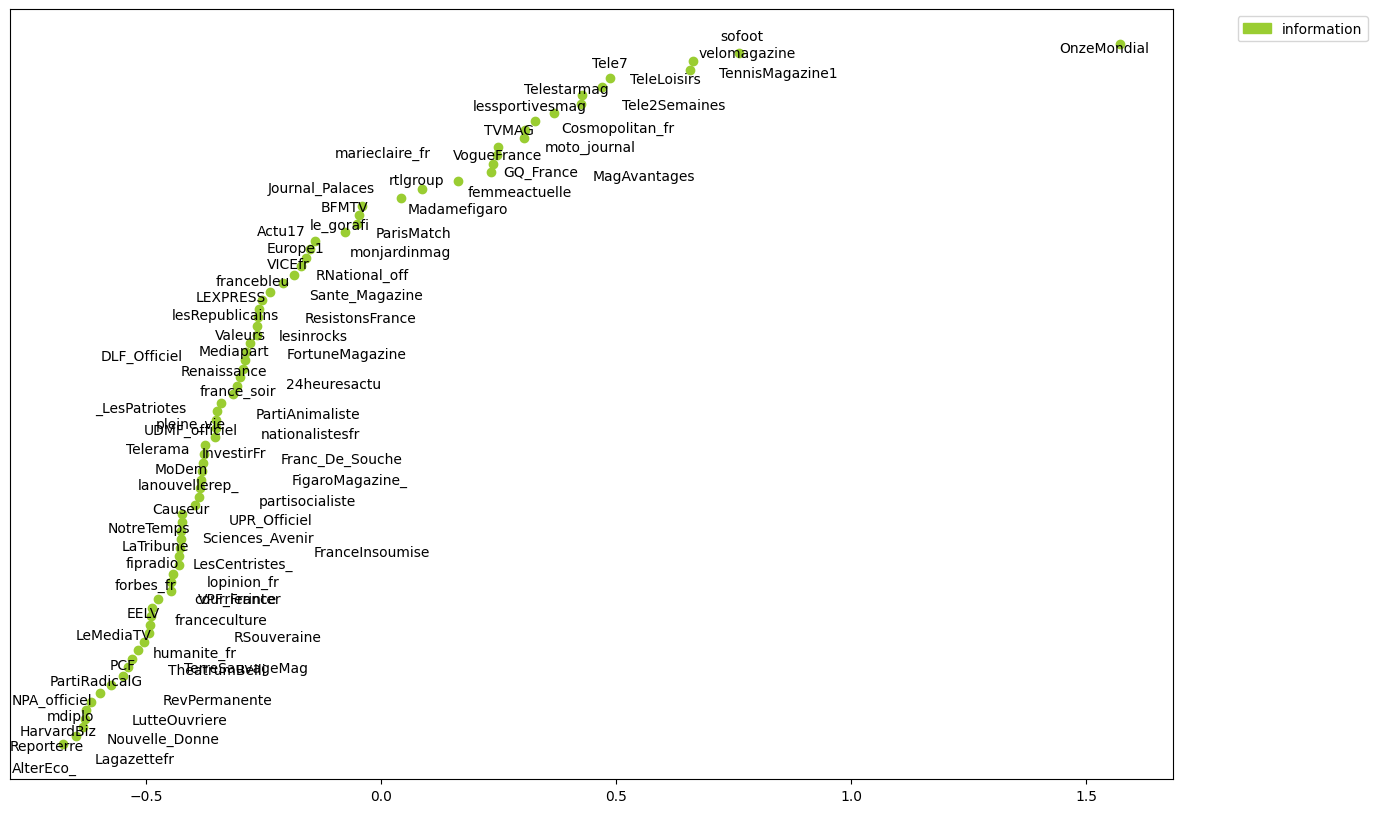

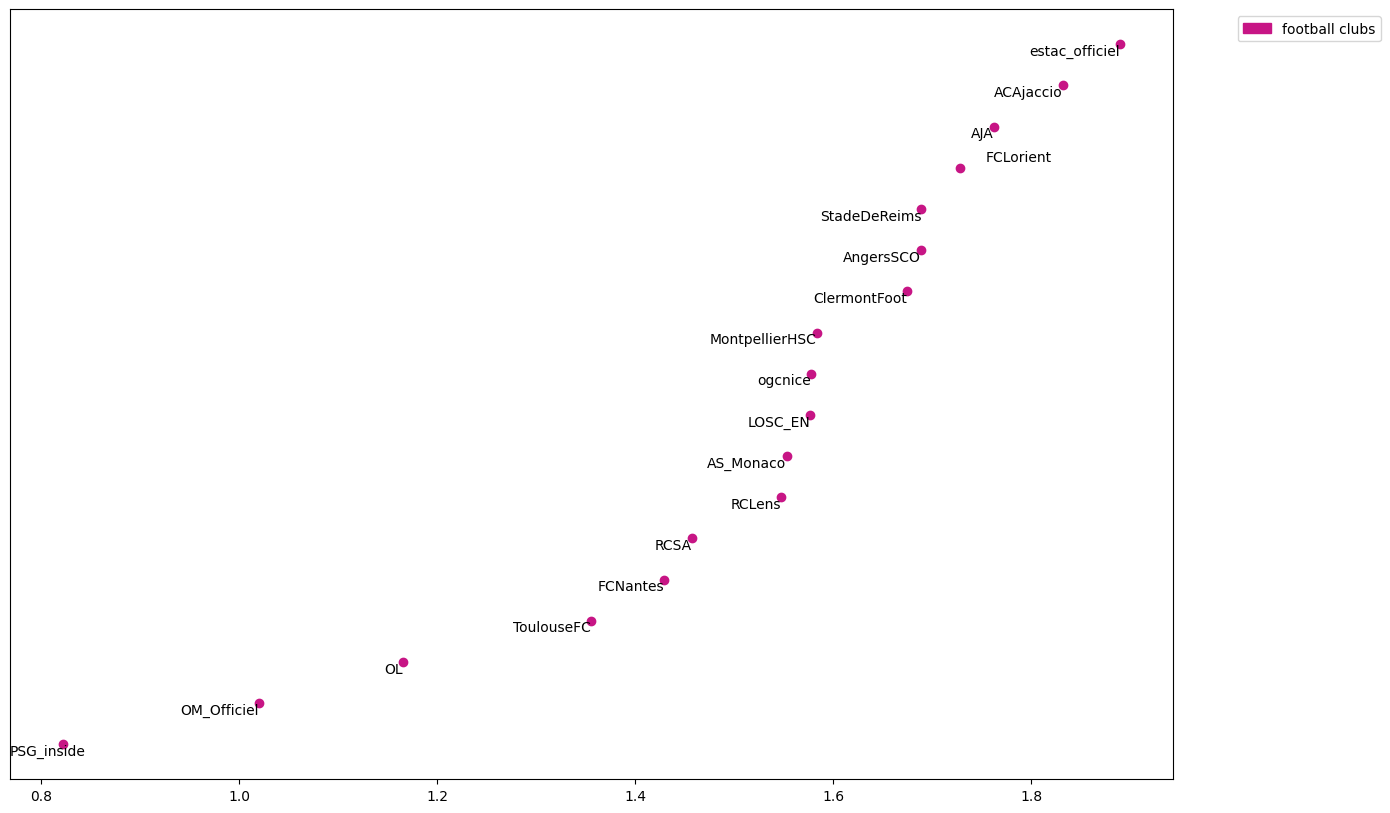

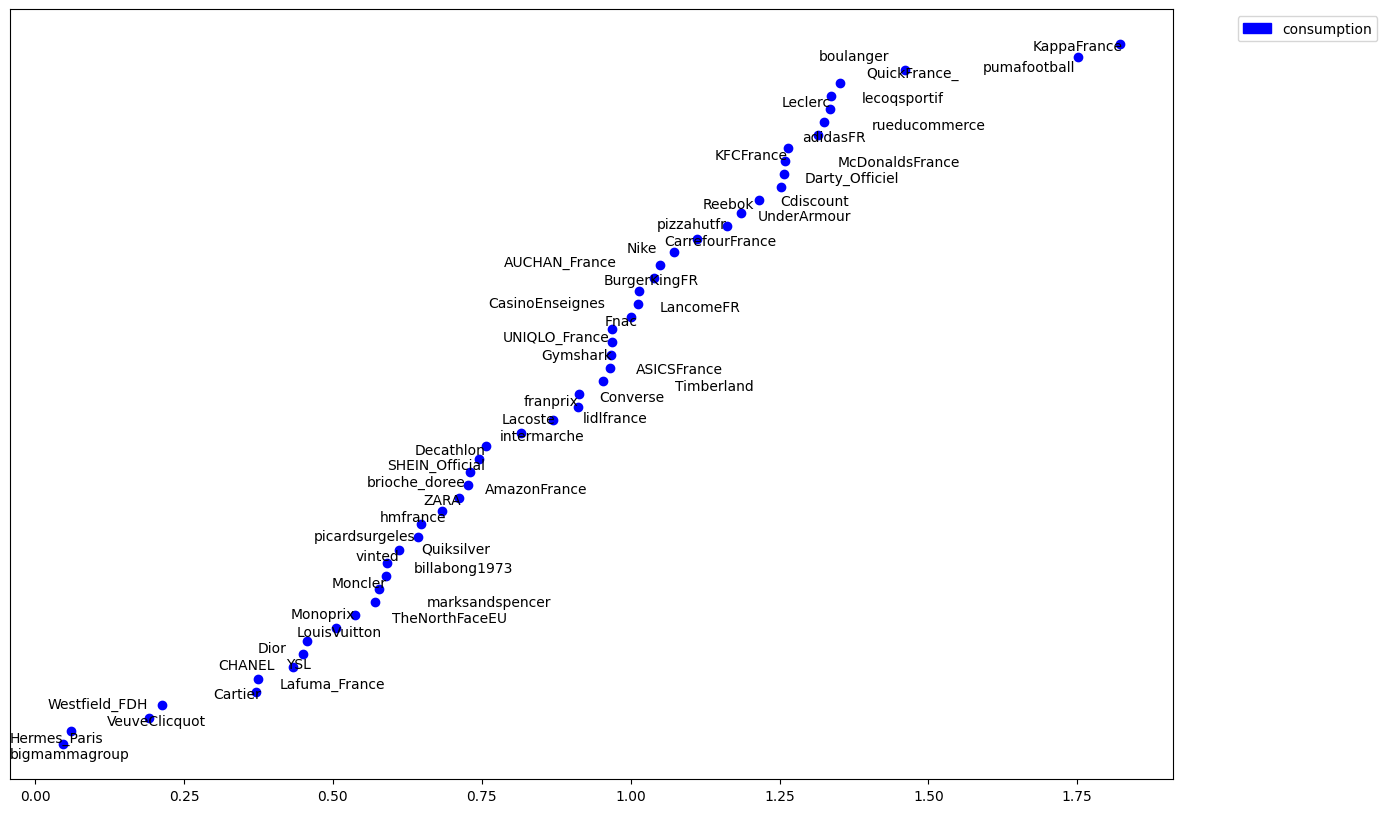

In [178]:
importlib.reload(graphfunk)
# Keep only one row per unique 'marker_id'
# new_types = edgelist_CA.drop_duplicates(subset='marker_id')

graphfunk.plot_type(edgelist_CA, column_coordinates, 'education', 'darkorange', 0)

graphfunk.plot_type(edgelist_CA, column_coordinates, 'information', 'yellowgreen', 0)

graphfunk.plot_type(edgelist_CA, column_coordinates, 'football clubs', 'mediumvioletred', 0)

graphfunk.plot_type(edgelist_CA, column_coordinates, 'consumption', 'blue', 0)







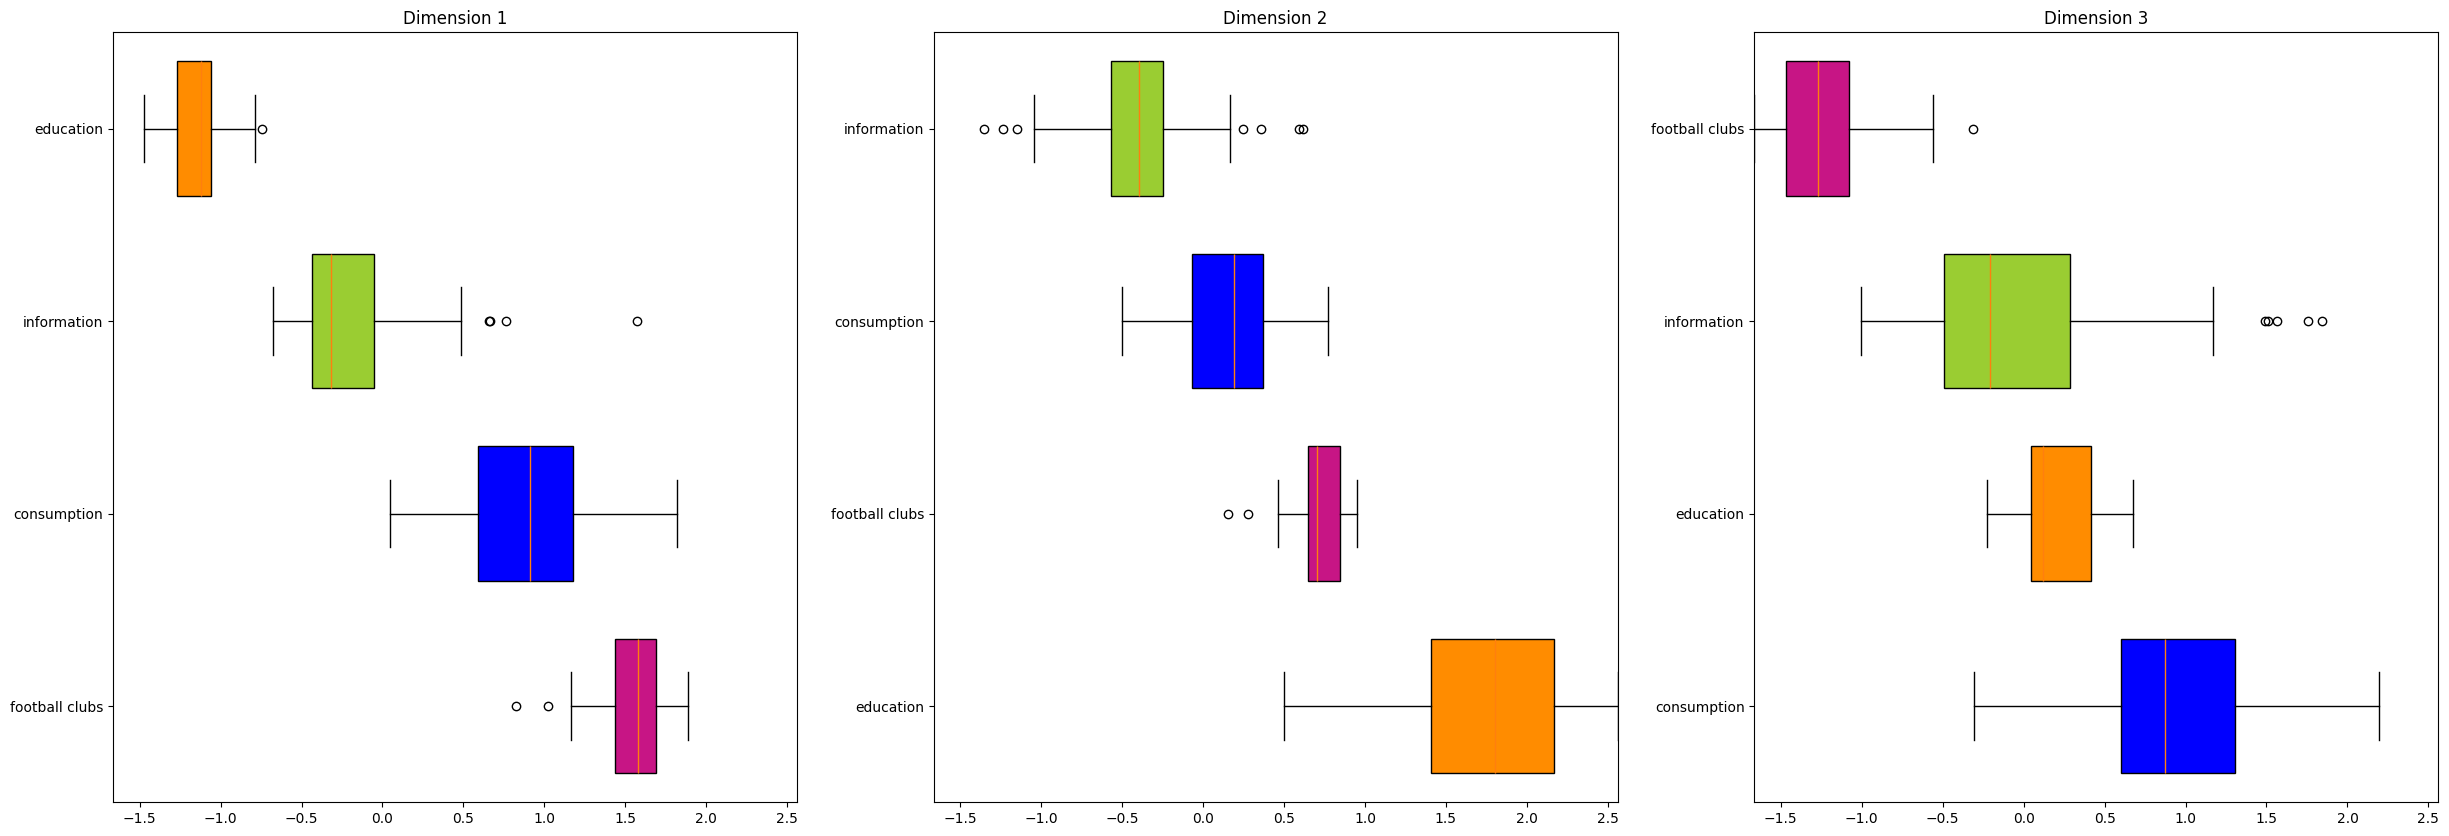

In [151]:
# Manually specify a color palette
color_dict = {'consumption': 'blue', 'information': 'yellowgreen', 'football clubs': 'mediumvioletred', 'education': 'darkorange'}


# Create a figure with 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(30, 10))

# Determine the minimum and maximum x-values for all data
x_min = column_coordinates.iloc[:, :3].min().min()
x_max = column_coordinates.iloc[:, :3].max().max()

for dim in range(3):
    # Calculate the median x-axis value for each type and sort in descending order
    type_order = column_coordinates.groupby('type2')[dim].median().sort_values(ascending=False).index

    # Create a box plot for each type
    for i, type_ in enumerate(type_order):
        data = column_coordinates[column_coordinates['type2'] == type_][dim]
        axs[dim].boxplot(data, positions=[i], patch_artist=True, boxprops=dict(facecolor=color_dict[type_]), vert=False, widths=0.7)

    # Set the y-axis labels and limit
    axs[dim].set_yticks(range(len(type_order)))
    axs[dim].set_yticklabels(type_order)
    axs[dim].set_title(f'Dimension {dim+1}')

    # Set the x-axis range
    axs[dim].set_xlim(x_min, x_max)

plt.show()

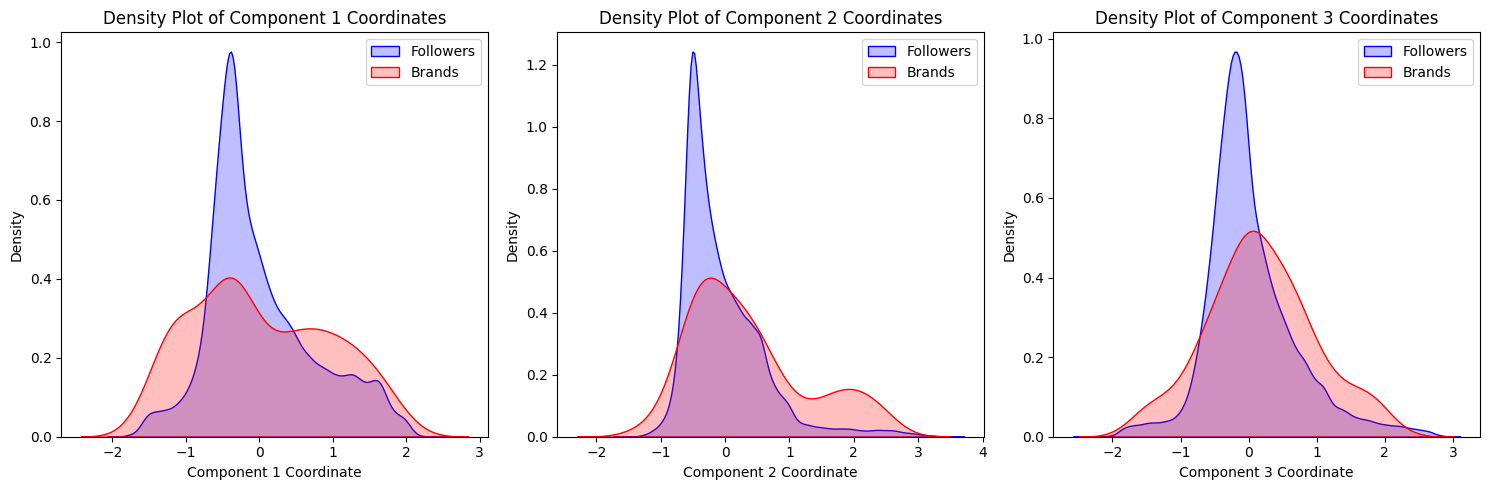

In [139]:
plt.figure(figsize=(15, 5))

for i in range(3):
    # Get the coordinates for the i-th component for followers and brands
    component_followers = row_coordinates.iloc[:, i]
    component_brands = column_coordinates.iloc[:, i]

    plt.subplot(1, 3, i+1)

    # Create a density plot for followers
    sns.kdeplot(component_followers, fill=True, color='b', label='Followers')

    # Create a density plot for brands
    sns.kdeplot(component_brands, fill=True, color='r', label='Brands')

    plt.xlabel(f'Component {i+1} Coordinate')
    plt.title(f'Density Plot of Component {i+1} Coordinates')
    plt.legend()

plt.tight_layout()
plt.show()

In [159]:
edgelist_CA.head()

,twitter_name,marker_id,follower_id,type,followers,french_followers,type2
0,Mediapart,19976004,1193293102162862080,media,3079643,64182,information
1,Mediapart,19976004,2884619299,media,3079643,64182,information
2,Mediapart,19976004,782999494703054848,media,3079643,64182,information
3,Mediapart,19976004,124458686,media,3079643,64182,information
4,Mediapart,19976004,2960220189,media,3079643,64182,information


In [182]:
eigenvalues

array([0.56214044, 0.44877454, 0.4218742 , 0.36589671, 0.29916887,
       0.25916294, 0.24343068, 0.20732504, 0.19133593, 0.18647077,
       0.1788122 , 0.17299796, 0.16998801, 0.1593688 , 0.15731445,
       0.14808699, 0.14302576, 0.12908866, 0.12775816, 0.12259526,
       0.12068594, 0.11888243, 0.11718971, 0.11577469, 0.11472499,
       0.11417934, 0.11228299, 0.11177864, 0.11011168, 0.10942952,
       0.10862347, 0.10819098, 0.10711833, 0.10632303, 0.10544845,
       0.10425558, 0.10387198, 0.10208109, 0.10100577, 0.10063308,
       0.099303  , 0.09894901, 0.09818512, 0.09812683, 0.09783049,
       0.09623148, 0.09610179, 0.0954526 , 0.09502747, 0.0949153 ,
       0.09467247, 0.09391174, 0.09349528, 0.09230066, 0.09198225,
       0.09152321, 0.09109014, 0.09044345, 0.09015257, 0.08981292,
       0.08942965, 0.08920743, 0.08856103, 0.08822087, 0.08805536,
       0.08748796, 0.08709508, 0.08668696, 0.08582878, 0.08508023,
       0.08489809, 0.0842067 , 0.08401147, 0.08380262, 0.08365

In [183]:
import matplotlib.cm as cm
coordinates = column_coordinates
coordinates3 = coordinates.iloc[:, :3]
eigenvalues = ca.eigenvalues_
eigenvalues3 = eigenvalues[:3]



# Calculate the contributions
contributions = coordinates3**2 / eigenvalues3


# Reset the index of contributions so that 'twitter_name' becomes a column
contributions.reset_index(inplace=True)

# Merge contributions with edgelist_CA on 'twitter_name'
contributions = contributions.merge(edgelist_CA[['twitter_name', 'type2']], on='twitter_name', how='left')


/tmp/ipykernel_983814/3218394201.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  bar_colors = cm.get_cmap(colors[j])(color_intensity)


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

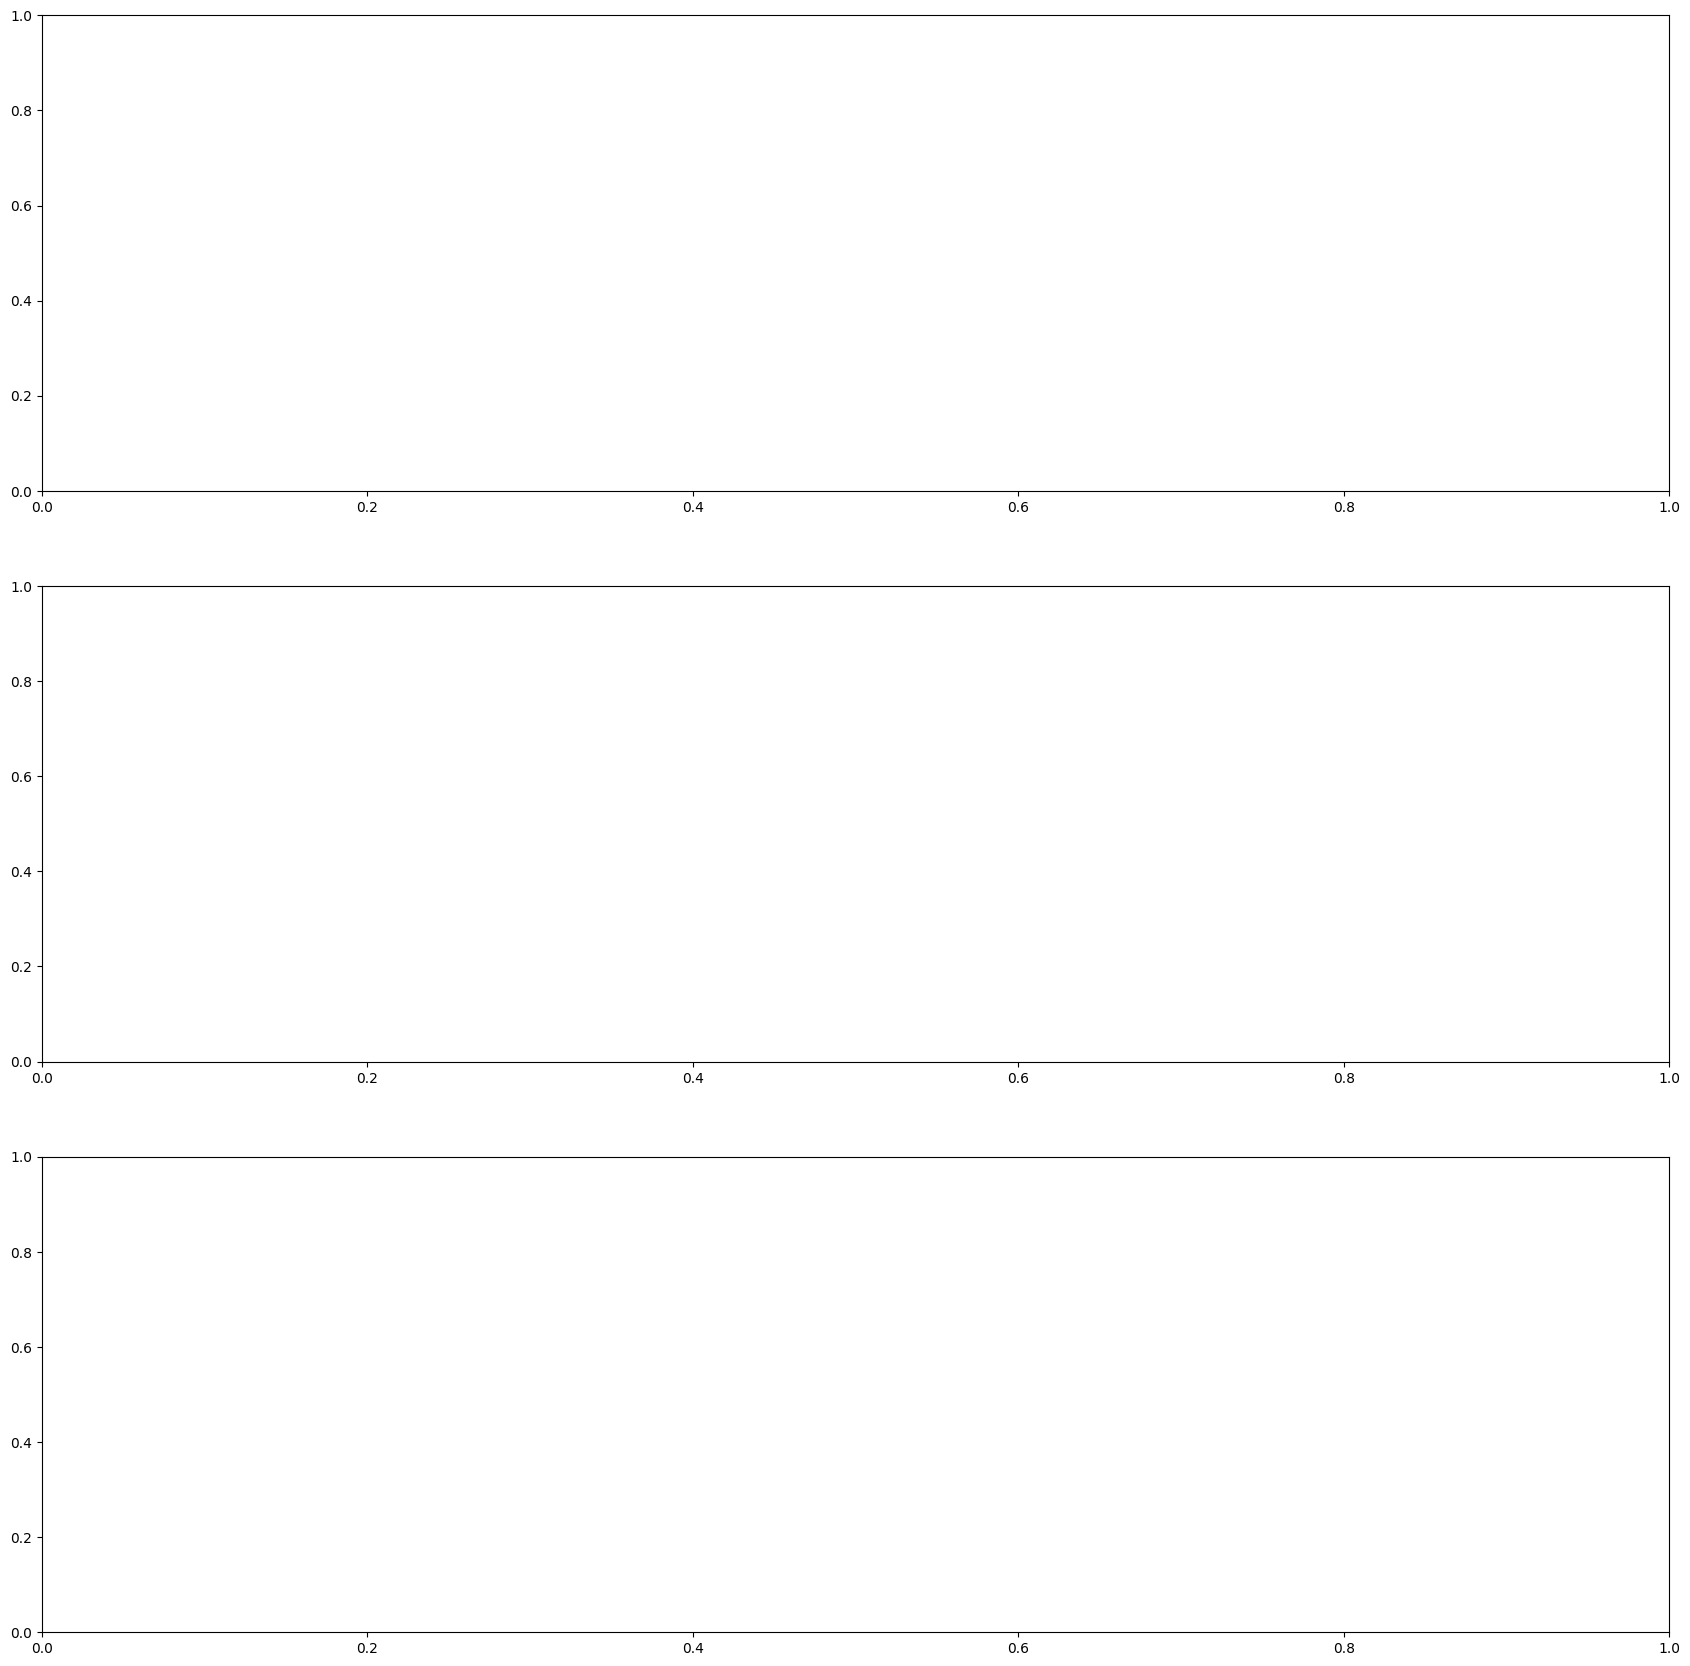

In [187]:
# Get the unique types
types = contributions['type2'].unique()

# Find the maximum contribution across all types and dimensions
max_contribution = contributions[[0, 1, 2]].max().max()

# Create a subplot for each dimension
fig, axs = plt.subplots(3, len(types), figsize=(21, 7 * 3))

# Define colors for each dimension
colors = ['Reds', 'Greens', 'Blues']

for j in range(3):  # Loop over dimensions
    for i, type in enumerate(types):  # Loop over types
        # Filter the contributions for the current type
        contributions_type = contributions[contributions['type2'] == type]

        # Calculate color intensity for each bar
        color_intensity = contributions_type[j] / max_contribution
        bar_colors = cm.get_cmap(colors[j])(color_intensity)

        axs[j, i].barh(contributions_type.index, contributions_type[j], color=bar_colors)
        axs[j, i].set_xlabel('Contribution')
        axs[j, i].set_title(f'Type: {type}, Dimension {j+1}')
        axs[j, i].set_xlim(0, max_contribution)  # Set the x-axis limit

plt.tight_layout()
plt.show()

In [ ]:
# Calculate the total contribution of each type to each dimension
total_contributions = contributions.groupby('type')[[0, 1, 2]].sum()

# Normalize the contributions so they add up to 100 for each dimension
total_contributions = total_contributions.divide(total_contributions.sum(), axis=1) * 100

# Define the color dictionary
color_dict = {'consumption': 'blue', 'information': 'yellowgreen', 'football clubs': 'mediumvioletred', 'education': 'darkorange'}

# Create a subplot for each dimension
fig, axs = plt.subplots(3, 1, figsize=(5, 9))

# Calculate the maximum contribution across all dimensions
max_contribution = total_contributions.max().max()

for i, ax in enumerate(axs):
    # Sort the total contributions for the current dimension
    total_contributions_sorted = total_contributions.sort_values(by=i, ascending=False)
    
    # Get the colors for the sorted types
    colors = total_contributions_sorted.index.map(color_dict.get)
    
    ax.barh(total_contributions_sorted.index, total_contributions_sorted[i], color=colors)
    ax.set_xlabel('Total Contribution (%)')
    ax.set_title(f'Dimension {i+1}')
    ax.set_xlim(0, max_contribution + 5)  # Set the x-axis limit to the maximum contribution

plt.tight_layout()
plt.show()

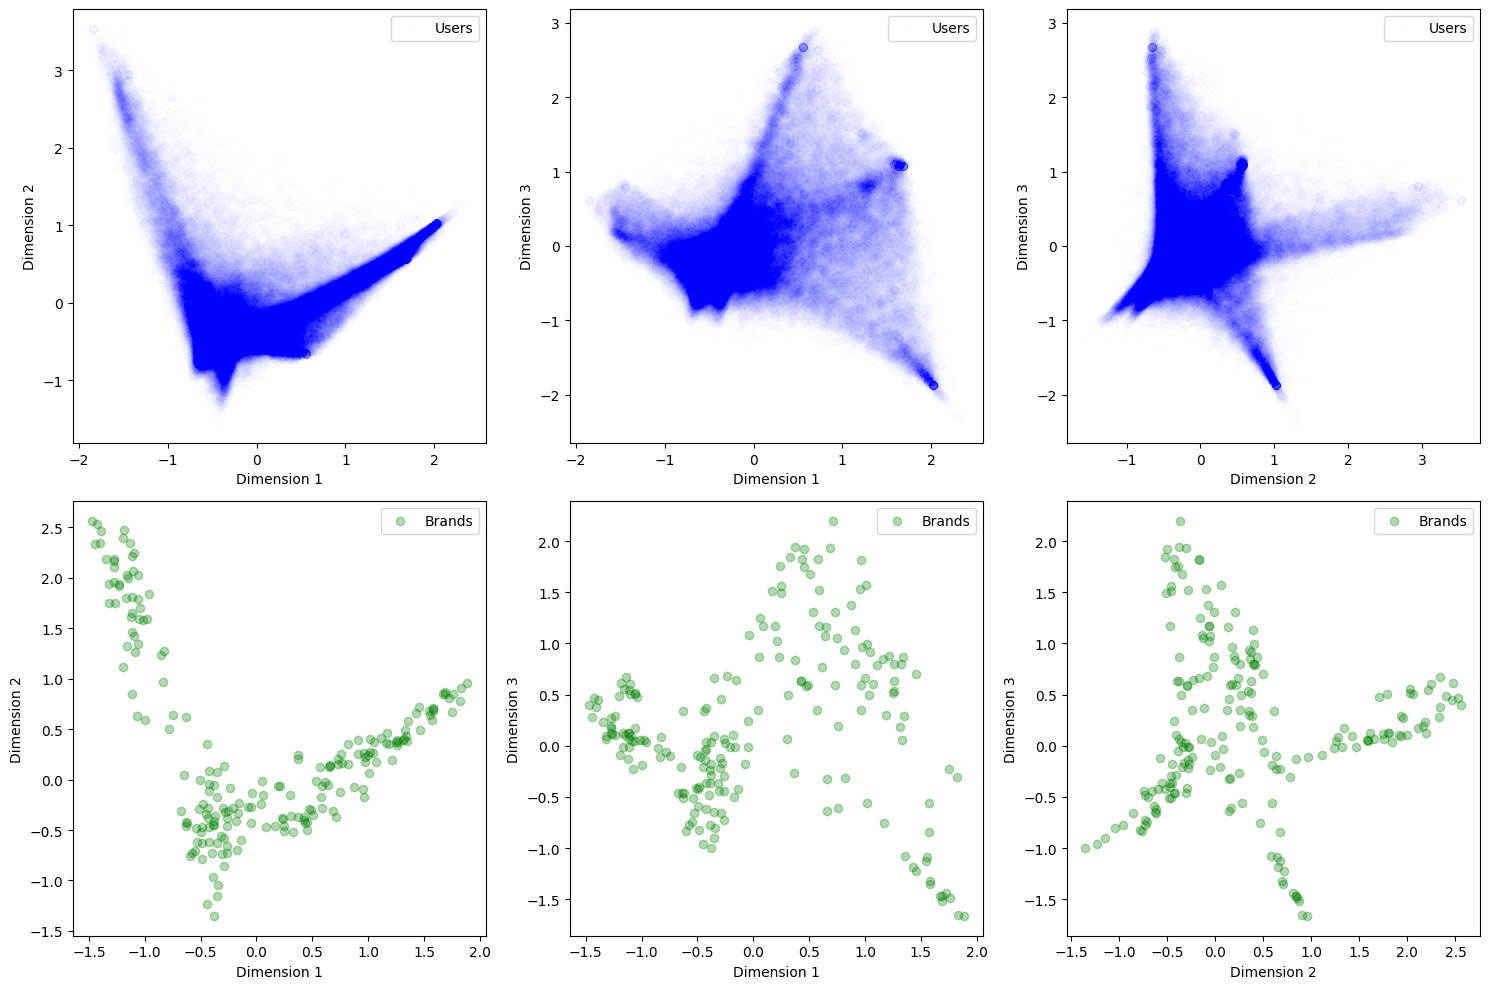

In [140]:
plt.figure(figsize=(15, 10))

# Plot for Users
plt.subplot(2, 3, 1)  # 2 rows, 3 columns, first plot
plt.scatter(row_coordinates[0], row_coordinates[1], color='blue', label='Users', alpha = 0.003)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()

plt.subplot(2, 3, 2)  # 2 rows, 3 columns, second plot
plt.scatter(row_coordinates[0], row_coordinates[2], color='blue', label='Users', alpha = 0.003)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 3')
plt.legend()

plt.subplot(2, 3, 3)  # 2 rows, 3 columns, third plot
plt.scatter(row_coordinates[1], row_coordinates[2], color='blue', label='Users', alpha = 0.003)
plt.xlabel('Dimension 2')
plt.ylabel('Dimension 3')
plt.legend()

# Plot for Brands
plt.subplot(2, 3, 4)  # 2 rows, 3 columns, fourth plot
plt.scatter(column_coordinates[0], column_coordinates[1], color='green', label='Brands', alpha = 0.3)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()

plt.subplot(2, 3, 5)  # 2 rows, 3 columns, fifth plot
plt.scatter(column_coordinates[0], column_coordinates[2], color='green', label='Brands', alpha = 0.3)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 3')
plt.legend()

plt.subplot(2, 3, 6)  # 2 rows, 3 columns, sixth plot
plt.scatter(column_coordinates[1], column_coordinates[2], color='green', label='Brands', alpha = 0.3)
plt.xlabel('Dimension 2')
plt.ylabel('Dimension 3')
plt.legend()

plt.tight_layout()
plt.show()

In [141]:
column_coordinates.head()

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,type2
twitter_name,,,,,,,,,,,,,,,,,,,,,
24heuresactu,-0.293984,-0.578044,-0.119875,0.021051,0.680728,-0.316786,-0.659470,-0.197418,-0.243188,-0.204380,...,-3.561458,1.620228,5.119642,-0.244709,-0.229280,-0.412554,-0.576843,0.833426,-0.858696,information
ACAjaccio,1.832167,0.904448,-1.652958,-1.353157,-0.025558,-0.041948,0.006717,0.720903,0.116874,-0.266917,...,0.259359,0.037048,0.128661,0.006515,-0.057395,-0.044863,-0.101117,-0.128680,0.126297,football clubs
AJA,1.762507,0.846269,-1.483433,-1.039978,-0.071851,-0.028801,0.007450,0.607826,0.106165,-0.197251,...,0.412403,0.207750,0.224529,0.006848,-0.106476,-0.009147,-0.175733,-0.260917,0.140963,football clubs
ASICSFrance,0.967124,0.260845,0.350225,-0.060710,-0.041817,0.041196,0.222464,-0.809558,0.157002,0.189904,...,0.024007,1.779610,0.427759,-1.336113,-0.679442,1.009443,-0.617206,-0.444078,0.337535,consumption
AS_Monaco,1.553025,0.644270,-1.086671,-0.801687,0.015671,-0.004364,0.055782,0.092235,0.042278,-0.003471,...,-0.195817,-0.178783,-0.031636,0.210510,-0.058960,-0.043540,-0.066657,-0.021473,-0.042547,football clubs


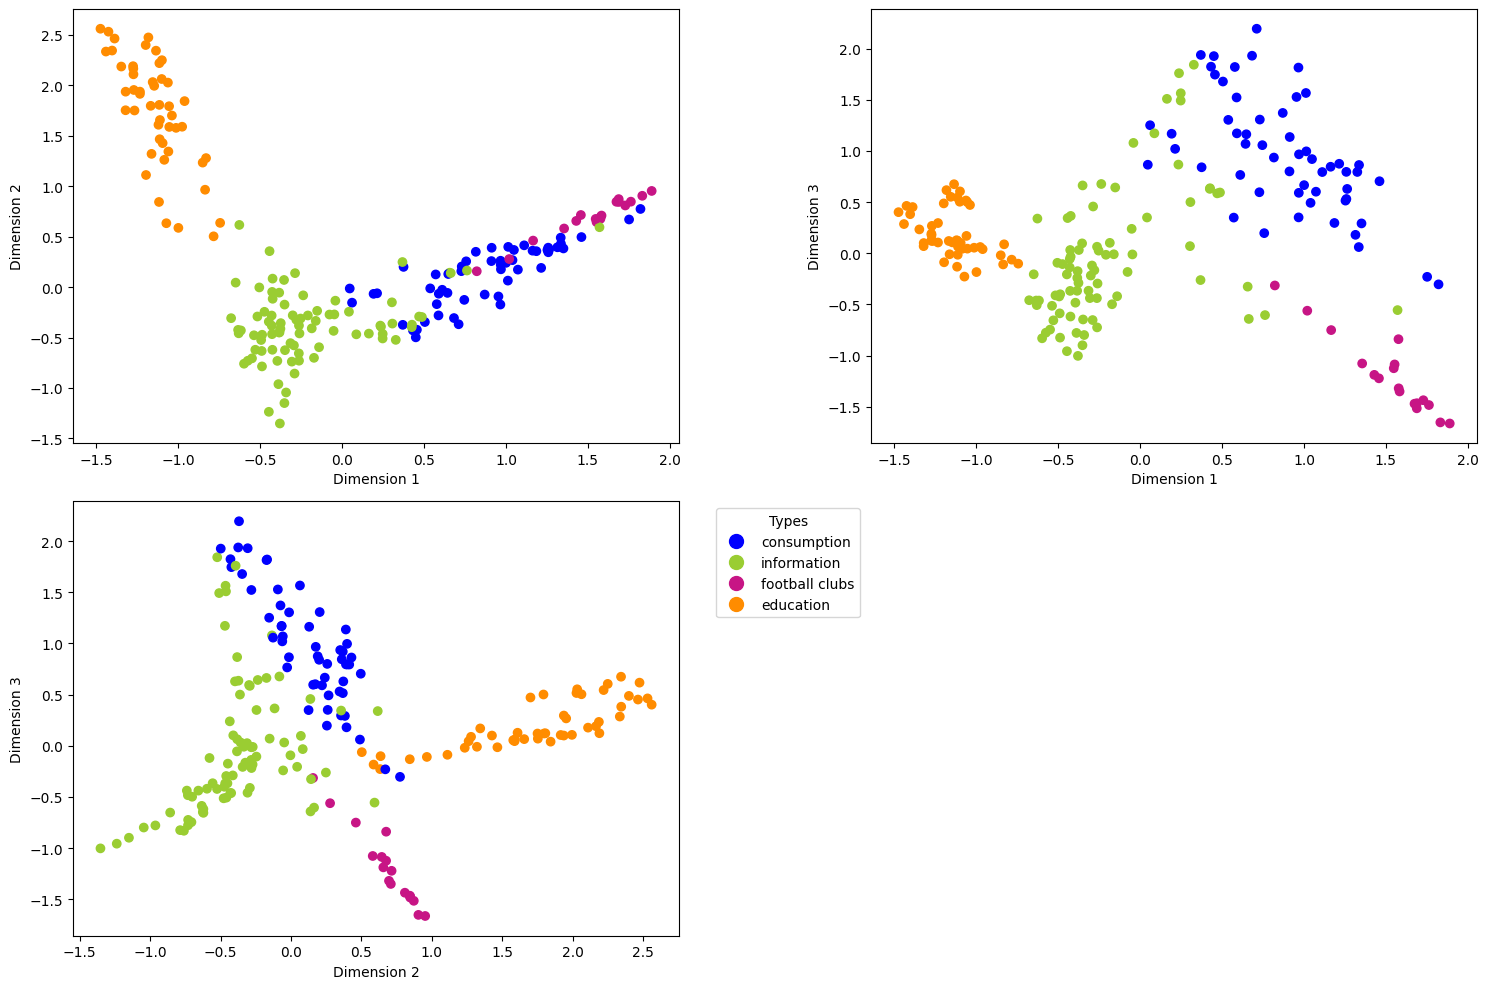

In [142]:
import matplotlib.lines as mlines

plt.figure(figsize=(15, 10))

# Manually specify a color palette
color_dict = {'consumption': 'blue', 'information': 'yellowgreen', 'football clubs': 'mediumvioletred', 'education': 'darkorange'}

plt.subplot(2, 2, 1)  # 2 rows, 2 columns, first plot
plt.scatter(column_coordinates[0], column_coordinates[1], c=[color_dict[t] for t in column_coordinates.type2])
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

plt.subplot(2, 2, 2)  # 2 rows, 2 columns, second plot
plt.scatter(column_coordinates[0], column_coordinates[2], c=[color_dict[t] for t in column_coordinates.type2])
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 3')

plt.subplot(2, 2, 3)  # 2 rows, 2 columns, third plot
plt.scatter(column_coordinates[1], column_coordinates[2], c=[color_dict[t] for t in column_coordinates.type2])
plt.xlabel('Dimension 2')
plt.ylabel('Dimension 3')

# Create legend
legend_handles = [mlines.Line2D([], [], color=color, marker='o', linestyle='', markersize=10) for color in color_dict.values()]
plt.legend(legend_handles, color_dict.keys(), bbox_to_anchor=(1.05, 1), loc='upper left', title="Types")

plt.tight_layout()
plt.show()

In [144]:
column_coordinates['type2'].unique()

array(['information', 'football clubs', 'consumption', 'education'],
      dtype=object)

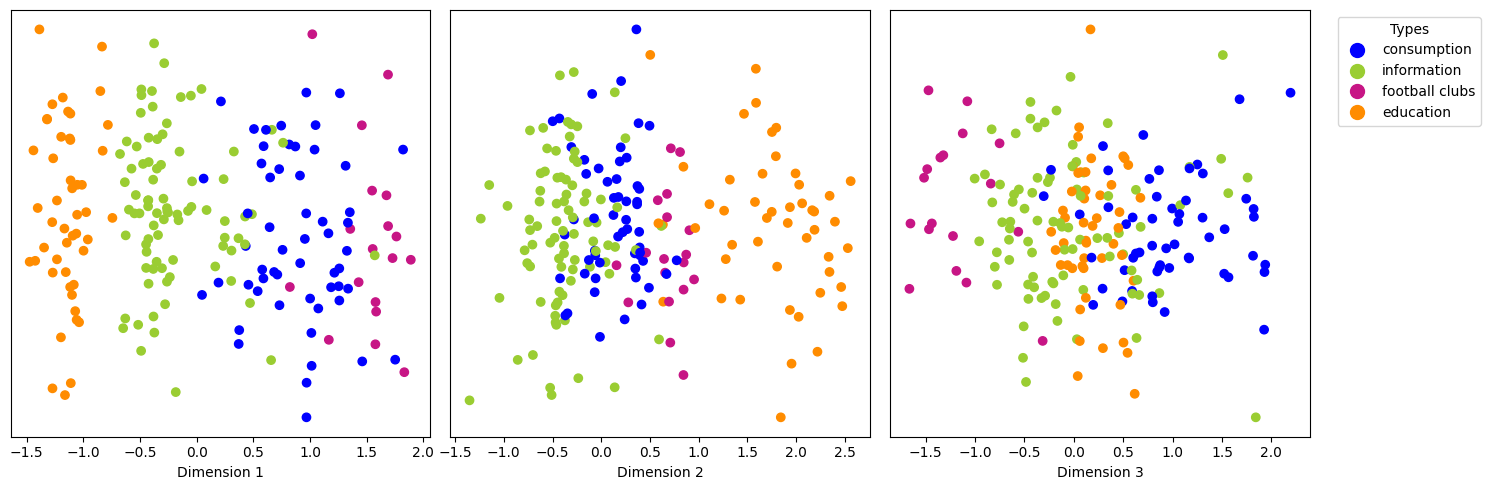

In [145]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Manually specify a color palette
color_dict = {'consumption': 'blue', 'information': 'yellowgreen', 'football clubs': 'mediumvioletred', 'education': 'darkorange'}

# Create an empty list to store the legend handles
legend_handles = [mlines.Line2D([], [], color=color, marker='o', linestyle='', markersize=10) for color in color_dict.values()]

# Iterate over the first three dimensions
for i in range(3):
    # Create an array of random values with the same length as column_coordinates[i]
    y = np.random.normal(0, 0.01, len(column_coordinates[i]))

    axs[i].scatter(column_coordinates[i], y, c=[color_dict[t] for t in column_coordinates.type2])
    axs[i].set_xlabel(f'Dimension {i+1}')
    axs[i].set_yticks([])  # Hide y-axis

# Add a single legend to the first subplot
axs[2].legend(legend_handles, color_dict.keys(), bbox_to_anchor=(1.05, 1), loc='upper left', title="Types")

plt.tight_layout()
plt.show()